# SMS Spam Classification

# SMS Spam Collection Dataset

### Dataset Description

This dataset includes 5572 rows and 2 feature variables. Each row corresponds to a text message, and includes the variable Category:

**Objective**
The objective is to classify whether the text message is ham or spam

**Columns**
1. Message: The text of the messages

2. Age: The category of which the text message belongs,comprised of two ham and spam
    

# 1. Importing the packages and the dataset

In [2]:
# Importing important packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

In [3]:
#importing the packages
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence

Using TensorFlow backend.


In [5]:
# Reading the dataset
spam = pd.read_csv('spam.csv')

In [6]:
# Getting the head of the dataset
spam.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Shape of the dataset
spam.shape

(5572, 2)

In [8]:
# Value counts of Category column
spam.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

# 2. Assigning parameters for embedding and performing label encoding

In [4]:
# Assigning parameters for embedding
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 8000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.25

In [9]:
# Converting category column into labels
spam['Category'] = spam['Category'].map({'ham':0,'spam':1}).astype(int)

# 3. Loading spacy model and assigning x and y

In [ ]:
### Import Spacy and model

import spacy
from spacy.util import minibatch, compounding
nlp = spacy.load('en_core_web_sm')

In [10]:
X = spam['Message']
y = spam['Category']

N = X.shape[0]

# 4. Performing Text Processing

In [12]:
# Removing stopwords and lemmatization

corpus = []

for i in range(0, N):
  doc = nlp(X[i])
  review = [token.lemma_ for token in doc if not token.is_stop]
  corpus.append(" ".join(review))

In [13]:
# Tokenization

t=Tokenizer(num_words=MAX_NB_WORDS)
t.fit_on_texts(corpus)
sequences = t.texts_to_sequences(corpus)

In [14]:
word_index = t.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 7816


In [15]:
# Sentence padding

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [16]:
# Sentence padding

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [17]:
# Converting the labels to categorical

labels = []

for idx in y:
  labels.append(idx)
  
labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

Shape of Data Tensor: (5572, 1000)
Shape of Label Tensor: (5572, 2)


# 5. Splitting the dataset and loading the Glove model

In [18]:
# Train Validation split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [19]:
# Loading Glove 6B 100d model

embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


# 6. Performing Text Embedding using Glove model

In [20]:
# Text embedding using Glove

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))        # Return an array of random numbers with the size provided
for word, i in word_index.items():                                               # For every word in the word index, find the embedding vector
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector                                   # Save the embedding vector in the embedding matrix

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

# 7. Training the CNN model

In [21]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)                             # The first layer consisting of embedding input
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)                    # The CNN layers
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)                                  # The output layer

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)   # Model Checkpointer callback

Instructions for updating:
Colocations handled automatically by placer.
Simplified convolutional neural network
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         781700    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_____________

# 8. Fitting the CNN model

In [22]:
# Fitting the model on train data and evaluation in Validation data

history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Instructions for updating:
Use tf.cast instead.
Train on 4179 samples, validate on 1393 samples
Epoch 1/15


 408/4179 [=>............................] - ETA: 30:52 - loss: 0.9299 - acc: 0.0000e+ - ETA: 16:45 - loss: 0.4860 - acc: 0.5000   - ETA: 11:57 - loss: 0.3240 - acc: 0.66 - ETA: 9:31 - loss: 1.6306 - acc: 0.6250 - ETA: 8:03 - loss: 1.3750 - acc: 0.700 - ETA: 7:05 - loss: 1.1720 - acc: 0.750 - ETA: 6:23 - loss: 1.0169 - acc: 0.785 - ETA: 5:50 - loss: 0.8947 - acc: 0.812 - ETA: 5:25 - loss: 0.7991 - acc: 0.833 - ETA: 5:06 - loss: 0.7206 - acc: 0.850 - ETA: 4:49 - loss: 0.6558 - acc: 0.863 - ETA: 4:35 - loss: 0.6017 - acc: 0.875 - ETA: 4:22 - loss: 0.5557 - acc: 0.884 - ETA: 4:12 - loss: 0.5162 - acc: 0.892 - ETA: 4:02 - loss: 0.4819 - acc: 0.900 - ETA: 3:55 - loss: 0.6717 - acc: 0.875 - ETA: 3:48 - loss: 0.6514 - acc: 0.882 - ETA: 3:41 - loss: 0.6253 - acc: 0.888 - ETA: 3:35 - loss: 0.5961 - acc: 0.894 - ETA: 3:31 - loss: 0.5687 - acc: 0.900 - ETA: 3:26 - loss: 0.5424 - acc: 0.904 - ETA: 3:22 - loss: 0.5182 - acc: 0.909 - ETA: 3:18 - loss: 0.4959 - acc: 0.913 - ETA: 3:14 - loss: 0.4755 -

2040/4179 [=============>................] - ETA: 1:12 - loss: 0.2984 - acc: 0.928 - ETA: 1:12 - loss: 0.2980 - acc: 0.928 - ETA: 1:12 - loss: 0.3010 - acc: 0.928 - ETA: 1:12 - loss: 0.3008 - acc: 0.928 - ETA: 1:12 - loss: 0.3005 - acc: 0.928 - ETA: 1:12 - loss: 0.3002 - acc: 0.928 - ETA: 1:12 - loss: 0.2998 - acc: 0.928 - ETA: 1:12 - loss: 0.3033 - acc: 0.927 - ETA: 1:11 - loss: 0.3029 - acc: 0.927 - ETA: 1:11 - loss: 0.3026 - acc: 0.928 - ETA: 1:11 - loss: 0.3022 - acc: 0.928 - ETA: 1:11 - loss: 0.3019 - acc: 0.928 - ETA: 1:11 - loss: 0.3015 - acc: 0.928 - ETA: 1:11 - loss: 0.3011 - acc: 0.928 - ETA: 1:11 - loss: 0.3008 - acc: 0.928 - ETA: 1:11 - loss: 0.3004 - acc: 0.928 - ETA: 1:11 - loss: 0.3001 - acc: 0.928 - ETA: 1:11 - loss: 0.2997 - acc: 0.928 - ETA: 1:11 - loss: 0.2994 - acc: 0.928 - ETA: 1:11 - loss: 0.2991 - acc: 0.928 - ETA: 1:11 - loss: 0.2987 - acc: 0.928 - ETA: 1:11 - loss: 0.2984 - acc: 0.929 - ETA: 1:11 - loss: 0.3026 - acc: 0.928 - ETA: 1:11 - loss: 0.3025 - acc: 0.9

2468/4179 [================>.............] - ETA: 1:00 - loss: 0.2768 - acc: 0.935 - ETA: 1:00 - loss: 0.2765 - acc: 0.935 - ETA: 1:00 - loss: 0.2762 - acc: 0.936 - ETA: 1:00 - loss: 0.2760 - acc: 0.936 - ETA: 1:00 - loss: 0.2757 - acc: 0.936 - ETA: 1:00 - loss: 0.2754 - acc: 0.936 - ETA: 1:00 - loss: 0.2752 - acc: 0.936 - ETA: 1:00 - loss: 0.2749 - acc: 0.936 - ETA: 1:00 - loss: 0.2746 - acc: 0.936 - ETA: 1:00 - loss: 0.2744 - acc: 0.936 - ETA: 1:00 - loss: 0.2741 - acc: 0.936 - ETA: 1:00 - loss: 0.2738 - acc: 0.936 - ETA: 1:00 - loss: 0.2736 - acc: 0.936 - ETA: 1:00 - loss: 0.2733 - acc: 0.936 - ETA: 1:00 - loss: 0.2730 - acc: 0.936 - ETA: 59s - loss: 0.2728 - acc: 0.936 - ETA: 59s - loss: 0.2725 - acc: 0.93 - ETA: 59s - loss: 0.2722 - acc: 0.93 - ETA: 59s - loss: 0.2720 - acc: 0.93 - ETA: 59s - loss: 0.2717 - acc: 0.93 - ETA: 59s - loss: 0.2727 - acc: 0.93 - ETA: 59s - loss: 0.2724 - acc: 0.93 - ETA: 59s - loss: 0.2722 - acc: 0.93 - ETA: 59s - loss: 0.2719 - acc: 0.93 - ETA: 59s - l

2898/4179 [===================>..........] - ETA: 49s - loss: 0.2677 - acc: 0.94 - ETA: 49s - loss: 0.2674 - acc: 0.94 - ETA: 49s - loss: 0.2672 - acc: 0.94 - ETA: 49s - loss: 0.2670 - acc: 0.94 - ETA: 48s - loss: 0.2668 - acc: 0.94 - ETA: 48s - loss: 0.2666 - acc: 0.94 - ETA: 48s - loss: 0.2664 - acc: 0.94 - ETA: 48s - loss: 0.2661 - acc: 0.94 - ETA: 48s - loss: 0.2659 - acc: 0.94 - ETA: 48s - loss: 0.2657 - acc: 0.94 - ETA: 48s - loss: 0.2655 - acc: 0.94 - ETA: 48s - loss: 0.2653 - acc: 0.94 - ETA: 48s - loss: 0.2651 - acc: 0.94 - ETA: 48s - loss: 0.2649 - acc: 0.94 - ETA: 48s - loss: 0.2647 - acc: 0.94 - ETA: 48s - loss: 0.2644 - acc: 0.94 - ETA: 48s - loss: 0.2642 - acc: 0.94 - ETA: 48s - loss: 0.2640 - acc: 0.94 - ETA: 48s - loss: 0.2638 - acc: 0.94 - ETA: 48s - loss: 0.2636 - acc: 0.94 - ETA: 48s - loss: 0.2634 - acc: 0.94 - ETA: 48s - loss: 0.2632 - acc: 0.94 - ETA: 47s - loss: 0.2630 - acc: 0.94 - ETA: 47s - loss: 0.2628 - acc: 0.94 - ETA: 47s - loss: 0.2626 - acc: 0.94 - ETA: 

3328/4179 [======================>.......] - ETA: 36s - loss: 0.2565 - acc: 0.94 - ETA: 36s - loss: 0.2568 - acc: 0.94 - ETA: 36s - loss: 0.2566 - acc: 0.94 - ETA: 36s - loss: 0.2565 - acc: 0.94 - ETA: 36s - loss: 0.2563 - acc: 0.94 - ETA: 36s - loss: 0.2561 - acc: 0.94 - ETA: 36s - loss: 0.2559 - acc: 0.94 - ETA: 36s - loss: 0.2558 - acc: 0.94 - ETA: 36s - loss: 0.2556 - acc: 0.94 - ETA: 36s - loss: 0.2556 - acc: 0.94 - ETA: 36s - loss: 0.2554 - acc: 0.94 - ETA: 36s - loss: 0.2553 - acc: 0.94 - ETA: 36s - loss: 0.2551 - acc: 0.94 - ETA: 35s - loss: 0.2549 - acc: 0.94 - ETA: 35s - loss: 0.2547 - acc: 0.94 - ETA: 35s - loss: 0.2546 - acc: 0.94 - ETA: 35s - loss: 0.2544 - acc: 0.94 - ETA: 35s - loss: 0.2542 - acc: 0.94 - ETA: 35s - loss: 0.2542 - acc: 0.94 - ETA: 35s - loss: 0.2540 - acc: 0.94 - ETA: 35s - loss: 0.2539 - acc: 0.94 - ETA: 35s - loss: 0.2537 - acc: 0.94 - ETA: 35s - loss: 0.2535 - acc: 0.94 - ETA: 35s - loss: 0.2544 - acc: 0.94 - ETA: 35s - loss: 0.2542 - acc: 0.94 - ETA: 

3764/4179 [==========================>...] - ETA: 24s - loss: 0.2450 - acc: 0.94 - ETA: 24s - loss: 0.2452 - acc: 0.94 - ETA: 24s - loss: 0.2451 - acc: 0.94 - ETA: 24s - loss: 0.2449 - acc: 0.94 - ETA: 24s - loss: 0.2448 - acc: 0.94 - ETA: 24s - loss: 0.2447 - acc: 0.94 - ETA: 23s - loss: 0.2445 - acc: 0.94 - ETA: 23s - loss: 0.2444 - acc: 0.94 - ETA: 23s - loss: 0.2442 - acc: 0.94 - ETA: 23s - loss: 0.2441 - acc: 0.94 - ETA: 23s - loss: 0.2439 - acc: 0.94 - ETA: 23s - loss: 0.2438 - acc: 0.94 - ETA: 23s - loss: 0.2436 - acc: 0.94 - ETA: 23s - loss: 0.2435 - acc: 0.94 - ETA: 23s - loss: 0.2435 - acc: 0.94 - ETA: 23s - loss: 0.2433 - acc: 0.94 - ETA: 23s - loss: 0.2432 - acc: 0.94 - ETA: 23s - loss: 0.2430 - acc: 0.94 - ETA: 23s - loss: 0.2429 - acc: 0.94 - ETA: 23s - loss: 0.2427 - acc: 0.94 - ETA: 23s - loss: 0.2426 - acc: 0.94 - ETA: 23s - loss: 0.2424 - acc: 0.94 - ETA: 23s - loss: 0.2423 - acc: 0.94 - ETA: 22s - loss: 0.2422 - acc: 0.94 - ETA: 22s - loss: 0.2420 - acc: 0.95 - ETA: 

4179/4179 [==============================] - ETA: 11s - loss: 0.2384 - acc: 0.95 - ETA: 11s - loss: 0.2383 - acc: 0.95 - ETA: 11s - loss: 0.2382 - acc: 0.95 - ETA: 11s - loss: 0.2381 - acc: 0.95 - ETA: 11s - loss: 0.2379 - acc: 0.95 - ETA: 11s - loss: 0.2378 - acc: 0.95 - ETA: 11s - loss: 0.2377 - acc: 0.95 - ETA: 11s - loss: 0.2376 - acc: 0.95 - ETA: 11s - loss: 0.2374 - acc: 0.95 - ETA: 11s - loss: 0.2373 - acc: 0.95 - ETA: 11s - loss: 0.2372 - acc: 0.95 - ETA: 11s - loss: 0.2371 - acc: 0.95 - ETA: 11s - loss: 0.2369 - acc: 0.95 - ETA: 11s - loss: 0.2379 - acc: 0.95 - ETA: 10s - loss: 0.2378 - acc: 0.95 - ETA: 10s - loss: 0.2377 - acc: 0.95 - ETA: 10s - loss: 0.2376 - acc: 0.95 - ETA: 10s - loss: 0.2375 - acc: 0.95 - ETA: 10s - loss: 0.2374 - acc: 0.95 - ETA: 10s - loss: 0.2372 - acc: 0.95 - ETA: 10s - loss: 0.2371 - acc: 0.95 - ETA: 10s - loss: 0.2370 - acc: 0.95 - ETA: 10s - loss: 0.2369 - acc: 0.95 - ETA: 10s - loss: 0.2367 - acc: 0.95 - ETA: 10s - loss: 0.2367 - acc: 0.95 - ETA: 

 396/4179 [=>............................] - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:52 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 4.8686e-05 - acc: 1.000 - ETA: 1:53 - loss: 4.5988e-05 - acc: 1.000 - ETA: 1:53 - loss: 4.3574e-05 - acc: 1.000 - ETA: 1:53 - loss: 4.1401e-05 - acc: 1.000 - ETA: 1:53 - loss: 3.9452e-05 - acc: 1.000 - ETA: 1:53 - loss: 3.7664e-05 - 

1212/4179 [=======>......................] - ETA: 1:33 - loss: 0.1291 - acc: 0.988 - ETA: 1:33 - loss: 0.1287 - acc: 0.988 - ETA: 1:33 - loss: 0.1284 - acc: 0.988 - ETA: 1:33 - loss: 0.1281 - acc: 0.988 - ETA: 1:33 - loss: 0.1278 - acc: 0.988 - ETA: 1:33 - loss: 0.1275 - acc: 0.989 - ETA: 1:33 - loss: 0.1272 - acc: 0.989 - ETA: 1:33 - loss: 0.1269 - acc: 0.989 - ETA: 1:33 - loss: 0.1265 - acc: 0.989 - ETA: 1:33 - loss: 0.1262 - acc: 0.989 - ETA: 1:33 - loss: 0.1259 - acc: 0.989 - ETA: 1:33 - loss: 0.1256 - acc: 0.989 - ETA: 1:33 - loss: 0.1253 - acc: 0.989 - ETA: 1:33 - loss: 0.1250 - acc: 0.989 - ETA: 1:33 - loss: 0.1247 - acc: 0.989 - ETA: 1:33 - loss: 0.1244 - acc: 0.989 - ETA: 1:33 - loss: 0.1241 - acc: 0.989 - ETA: 1:33 - loss: 0.1238 - acc: 0.989 - ETA: 1:33 - loss: 0.1235 - acc: 0.989 - ETA: 1:33 - loss: 0.1233 - acc: 0.989 - ETA: 1:33 - loss: 0.1230 - acc: 0.989 - ETA: 1:33 - loss: 0.1227 - acc: 0.989 - ETA: 1:33 - loss: 0.1224 - acc: 0.989 - ETA: 1:32 - loss: 0.1221 - acc: 0.9

1620/4179 [==========>...................] - ETA: 1:22 - loss: 0.1420 - acc: 0.987 - ETA: 1:22 - loss: 0.1418 - acc: 0.987 - ETA: 1:22 - loss: 0.1416 - acc: 0.987 - ETA: 1:22 - loss: 0.1413 - acc: 0.987 - ETA: 1:22 - loss: 0.1411 - acc: 0.987 - ETA: 1:22 - loss: 0.1409 - acc: 0.987 - ETA: 1:22 - loss: 0.1406 - acc: 0.987 - ETA: 1:22 - loss: 0.1404 - acc: 0.987 - ETA: 1:21 - loss: 0.1406 - acc: 0.987 - ETA: 1:21 - loss: 0.1403 - acc: 0.987 - ETA: 1:21 - loss: 0.1401 - acc: 0.987 - ETA: 1:21 - loss: 0.1399 - acc: 0.987 - ETA: 1:21 - loss: 0.1397 - acc: 0.987 - ETA: 1:21 - loss: 0.1394 - acc: 0.987 - ETA: 1:21 - loss: 0.1392 - acc: 0.987 - ETA: 1:21 - loss: 0.1390 - acc: 0.987 - ETA: 1:21 - loss: 0.1388 - acc: 0.988 - ETA: 1:21 - loss: 0.1387 - acc: 0.988 - ETA: 1:21 - loss: 0.1384 - acc: 0.988 - ETA: 1:21 - loss: 0.1382 - acc: 0.988 - ETA: 1:21 - loss: 0.1380 - acc: 0.988 - ETA: 1:21 - loss: 0.1378 - acc: 0.988 - ETA: 1:21 - loss: 0.1376 - acc: 0.988 - ETA: 1:21 - loss: 0.1373 - acc: 0.9

2030/4179 [=============>................] - ETA: 1:10 - loss: 0.1365 - acc: 0.988 - ETA: 1:10 - loss: 0.1363 - acc: 0.988 - ETA: 1:10 - loss: 0.1362 - acc: 0.988 - ETA: 1:10 - loss: 0.1360 - acc: 0.988 - ETA: 1:10 - loss: 0.1358 - acc: 0.989 - ETA: 1:10 - loss: 0.1357 - acc: 0.989 - ETA: 1:10 - loss: 0.1355 - acc: 0.989 - ETA: 1:10 - loss: 0.1353 - acc: 0.989 - ETA: 1:10 - loss: 0.1352 - acc: 0.989 - ETA: 1:10 - loss: 0.1350 - acc: 0.989 - ETA: 1:10 - loss: 0.1349 - acc: 0.989 - ETA: 1:10 - loss: 0.1347 - acc: 0.989 - ETA: 1:10 - loss: 0.1345 - acc: 0.989 - ETA: 1:10 - loss: 0.1344 - acc: 0.989 - ETA: 1:09 - loss: 0.1342 - acc: 0.989 - ETA: 1:09 - loss: 0.1340 - acc: 0.989 - ETA: 1:09 - loss: 0.1339 - acc: 0.989 - ETA: 1:09 - loss: 0.1337 - acc: 0.989 - ETA: 1:09 - loss: 0.1401 - acc: 0.988 - ETA: 1:09 - loss: 0.1399 - acc: 0.988 - ETA: 1:09 - loss: 0.1397 - acc: 0.988 - ETA: 1:09 - loss: 0.1396 - acc: 0.988 - ETA: 1:09 - loss: 0.1394 - acc: 0.988 - ETA: 1:09 - loss: 0.1392 - acc: 0.9

2460/4179 [================>.............] - ETA: 59s - loss: 0.1420 - acc: 0.98 - ETA: 59s - loss: 0.1419 - acc: 0.98 - ETA: 59s - loss: 0.1417 - acc: 0.98 - ETA: 58s - loss: 0.1416 - acc: 0.98 - ETA: 58s - loss: 0.1415 - acc: 0.98 - ETA: 58s - loss: 0.1413 - acc: 0.98 - ETA: 58s - loss: 0.1412 - acc: 0.98 - ETA: 58s - loss: 0.1410 - acc: 0.98 - ETA: 58s - loss: 0.1409 - acc: 0.98 - ETA: 58s - loss: 0.1408 - acc: 0.98 - ETA: 58s - loss: 0.1406 - acc: 0.98 - ETA: 58s - loss: 0.1405 - acc: 0.98 - ETA: 58s - loss: 0.1404 - acc: 0.98 - ETA: 58s - loss: 0.1402 - acc: 0.98 - ETA: 58s - loss: 0.1401 - acc: 0.98 - ETA: 58s - loss: 0.1400 - acc: 0.98 - ETA: 58s - loss: 0.1398 - acc: 0.98 - ETA: 58s - loss: 0.1397 - acc: 0.98 - ETA: 58s - loss: 0.1395 - acc: 0.98 - ETA: 58s - loss: 0.1394 - acc: 0.98 - ETA: 58s - loss: 0.1393 - acc: 0.98 - ETA: 57s - loss: 0.1468 - acc: 0.98 - ETA: 57s - loss: 0.1467 - acc: 0.98 - ETA: 57s - loss: 0.1465 - acc: 0.98 - ETA: 57s - loss: 0.1464 - acc: 0.98 - ETA: 

2906/4179 [===================>..........] - ETA: 47s - loss: 0.1489 - acc: 0.98 - ETA: 47s - loss: 0.1488 - acc: 0.98 - ETA: 47s - loss: 0.1487 - acc: 0.98 - ETA: 47s - loss: 0.1486 - acc: 0.98 - ETA: 47s - loss: 0.1484 - acc: 0.98 - ETA: 47s - loss: 0.1483 - acc: 0.98 - ETA: 47s - loss: 0.1482 - acc: 0.98 - ETA: 47s - loss: 0.1481 - acc: 0.98 - ETA: 47s - loss: 0.1480 - acc: 0.98 - ETA: 47s - loss: 0.1479 - acc: 0.98 - ETA: 47s - loss: 0.1477 - acc: 0.98 - ETA: 47s - loss: 0.1476 - acc: 0.98 - ETA: 47s - loss: 0.1475 - acc: 0.98 - ETA: 47s - loss: 0.1474 - acc: 0.98 - ETA: 46s - loss: 0.1473 - acc: 0.98 - ETA: 46s - loss: 0.1471 - acc: 0.98 - ETA: 46s - loss: 0.1470 - acc: 0.98 - ETA: 46s - loss: 0.1469 - acc: 0.98 - ETA: 46s - loss: 0.1468 - acc: 0.98 - ETA: 46s - loss: 0.1468 - acc: 0.98 - ETA: 46s - loss: 0.1467 - acc: 0.98 - ETA: 46s - loss: 0.1466 - acc: 0.98 - ETA: 46s - loss: 0.1464 - acc: 0.98 - ETA: 46s - loss: 0.1463 - acc: 0.98 - ETA: 46s - loss: 0.1462 - acc: 0.98 - ETA: 

3336/4179 [======================>.......] - ETA: 35s - loss: 0.1353 - acc: 0.98 - ETA: 35s - loss: 0.1352 - acc: 0.98 - ETA: 35s - loss: 0.1351 - acc: 0.98 - ETA: 35s - loss: 0.1350 - acc: 0.98 - ETA: 35s - loss: 0.1349 - acc: 0.98 - ETA: 35s - loss: 0.1348 - acc: 0.98 - ETA: 35s - loss: 0.1348 - acc: 0.98 - ETA: 35s - loss: 0.1347 - acc: 0.98 - ETA: 35s - loss: 0.1346 - acc: 0.98 - ETA: 35s - loss: 0.1345 - acc: 0.98 - ETA: 35s - loss: 0.1344 - acc: 0.98 - ETA: 35s - loss: 0.1343 - acc: 0.98 - ETA: 35s - loss: 0.1342 - acc: 0.98 - ETA: 34s - loss: 0.1341 - acc: 0.98 - ETA: 34s - loss: 0.1340 - acc: 0.98 - ETA: 34s - loss: 0.1358 - acc: 0.98 - ETA: 34s - loss: 0.1357 - acc: 0.98 - ETA: 34s - loss: 0.1356 - acc: 0.98 - ETA: 34s - loss: 0.1355 - acc: 0.98 - ETA: 34s - loss: 0.1354 - acc: 0.98 - ETA: 34s - loss: 0.1353 - acc: 0.98 - ETA: 34s - loss: 0.1353 - acc: 0.98 - ETA: 34s - loss: 0.1352 - acc: 0.98 - ETA: 34s - loss: 0.1351 - acc: 0.98 - ETA: 34s - loss: 0.1350 - acc: 0.98 - ETA: 

3766/4179 [==========================>...] - ETA: 24s - loss: 0.1306 - acc: 0.98 - ETA: 24s - loss: 0.1306 - acc: 0.98 - ETA: 24s - loss: 0.1305 - acc: 0.98 - ETA: 24s - loss: 0.1304 - acc: 0.98 - ETA: 23s - loss: 0.1303 - acc: 0.98 - ETA: 23s - loss: 0.1303 - acc: 0.98 - ETA: 23s - loss: 0.1302 - acc: 0.98 - ETA: 23s - loss: 0.1301 - acc: 0.98 - ETA: 23s - loss: 0.1301 - acc: 0.98 - ETA: 23s - loss: 0.1300 - acc: 0.98 - ETA: 23s - loss: 0.1299 - acc: 0.98 - ETA: 23s - loss: 0.1298 - acc: 0.98 - ETA: 23s - loss: 0.1297 - acc: 0.98 - ETA: 23s - loss: 0.1297 - acc: 0.98 - ETA: 23s - loss: 0.1296 - acc: 0.98 - ETA: 23s - loss: 0.1295 - acc: 0.98 - ETA: 23s - loss: 0.1294 - acc: 0.98 - ETA: 23s - loss: 0.1294 - acc: 0.98 - ETA: 23s - loss: 0.1293 - acc: 0.98 - ETA: 23s - loss: 0.1292 - acc: 0.98 - ETA: 23s - loss: 0.1291 - acc: 0.98 - ETA: 22s - loss: 0.1291 - acc: 0.98 - ETA: 22s - loss: 0.1290 - acc: 0.98 - ETA: 22s - loss: 0.1289 - acc: 0.98 - ETA: 22s - loss: 0.1288 - acc: 0.98 - ETA: 

4179/4179 [==============================] - ETA: 11s - loss: 0.1286 - acc: 0.98 - ETA: 11s - loss: 0.1286 - acc: 0.98 - ETA: 11s - loss: 0.1285 - acc: 0.98 - ETA: 11s - loss: 0.1284 - acc: 0.98 - ETA: 11s - loss: 0.1283 - acc: 0.98 - ETA: 11s - loss: 0.1283 - acc: 0.98 - ETA: 11s - loss: 0.1282 - acc: 0.98 - ETA: 11s - loss: 0.1281 - acc: 0.98 - ETA: 11s - loss: 0.1281 - acc: 0.98 - ETA: 11s - loss: 0.1323 - acc: 0.98 - ETA: 11s - loss: 0.1322 - acc: 0.98 - ETA: 11s - loss: 0.1321 - acc: 0.98 - ETA: 11s - loss: 0.1321 - acc: 0.98 - ETA: 11s - loss: 0.1320 - acc: 0.98 - ETA: 11s - loss: 0.1319 - acc: 0.98 - ETA: 11s - loss: 0.1319 - acc: 0.98 - ETA: 10s - loss: 0.1318 - acc: 0.98 - ETA: 10s - loss: 0.1317 - acc: 0.98 - ETA: 10s - loss: 0.1325 - acc: 0.98 - ETA: 10s - loss: 0.1324 - acc: 0.98 - ETA: 10s - loss: 0.1324 - acc: 0.98 - ETA: 10s - loss: 0.1323 - acc: 0.98 - ETA: 10s - loss: 0.1322 - acc: 0.98 - ETA: 10s - loss: 0.1322 - acc: 0.98 - ETA: 10s - loss: 0.1321 - acc: 0.98 - ETA: 

 378/4179 [=>............................] - ETA: 1:56 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:53 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:52 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:52 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - 

2116/4179 [==============>...............] - ETA: 1:06 - loss: 0.0972 - acc: 0.988 - ETA: 1:06 - loss: 0.0971 - acc: 0.988 - ETA: 1:06 - loss: 0.0970 - acc: 0.988 - ETA: 1:06 - loss: 0.0973 - acc: 0.988 - ETA: 1:06 - loss: 0.0972 - acc: 0.988 - ETA: 1:06 - loss: 0.0971 - acc: 0.988 - ETA: 1:06 - loss: 0.0970 - acc: 0.988 - ETA: 1:06 - loss: 0.0969 - acc: 0.988 - ETA: 1:06 - loss: 0.0967 - acc: 0.988 - ETA: 1:06 - loss: 0.0966 - acc: 0.988 - ETA: 1:06 - loss: 0.0965 - acc: 0.988 - ETA: 1:06 - loss: 0.0964 - acc: 0.988 - ETA: 1:06 - loss: 0.0963 - acc: 0.988 - ETA: 1:06 - loss: 0.0962 - acc: 0.988 - ETA: 1:06 - loss: 0.0961 - acc: 0.988 - ETA: 1:06 - loss: 0.0960 - acc: 0.988 - ETA: 1:05 - loss: 0.0959 - acc: 0.988 - ETA: 1:05 - loss: 0.0957 - acc: 0.988 - ETA: 1:05 - loss: 0.0956 - acc: 0.988 - ETA: 1:05 - loss: 0.0955 - acc: 0.988 - ETA: 1:05 - loss: 0.0954 - acc: 0.988 - ETA: 1:05 - loss: 0.0953 - acc: 0.988 - ETA: 1:05 - loss: 0.0952 - acc: 0.988 - ETA: 1:05 - loss: 0.0951 - acc: 0.9

2546/4179 [=================>............] - ETA: 55s - loss: 0.0949 - acc: 0.98 - ETA: 55s - loss: 0.0948 - acc: 0.98 - ETA: 55s - loss: 0.0947 - acc: 0.98 - ETA: 55s - loss: 0.0946 - acc: 0.98 - ETA: 55s - loss: 0.0945 - acc: 0.98 - ETA: 55s - loss: 0.0944 - acc: 0.98 - ETA: 55s - loss: 0.0944 - acc: 0.98 - ETA: 55s - loss: 0.0943 - acc: 0.98 - ETA: 55s - loss: 0.0942 - acc: 0.98 - ETA: 55s - loss: 0.0941 - acc: 0.98 - ETA: 54s - loss: 0.0940 - acc: 0.98 - ETA: 54s - loss: 0.0939 - acc: 0.98 - ETA: 54s - loss: 0.0938 - acc: 0.98 - ETA: 54s - loss: 0.0937 - acc: 0.98 - ETA: 54s - loss: 0.0937 - acc: 0.98 - ETA: 54s - loss: 0.0936 - acc: 0.98 - ETA: 54s - loss: 0.0935 - acc: 0.98 - ETA: 54s - loss: 0.0934 - acc: 0.98 - ETA: 54s - loss: 0.0933 - acc: 0.98 - ETA: 54s - loss: 0.0932 - acc: 0.98 - ETA: 54s - loss: 0.0931 - acc: 0.98 - ETA: 54s - loss: 0.0930 - acc: 0.98 - ETA: 54s - loss: 0.0930 - acc: 0.98 - ETA: 54s - loss: 0.0929 - acc: 0.98 - ETA: 54s - loss: 0.0928 - acc: 0.98 - ETA: 

2976/4179 [====================>.........] - ETA: 43s - loss: 0.0979 - acc: 0.98 - ETA: 43s - loss: 0.0978 - acc: 0.98 - ETA: 43s - loss: 0.0977 - acc: 0.98 - ETA: 43s - loss: 0.1039 - acc: 0.98 - ETA: 43s - loss: 0.1039 - acc: 0.98 - ETA: 43s - loss: 0.1038 - acc: 0.98 - ETA: 43s - loss: 0.1037 - acc: 0.98 - ETA: 43s - loss: 0.1036 - acc: 0.98 - ETA: 43s - loss: 0.1035 - acc: 0.98 - ETA: 43s - loss: 0.1035 - acc: 0.98 - ETA: 43s - loss: 0.1034 - acc: 0.98 - ETA: 43s - loss: 0.1033 - acc: 0.98 - ETA: 43s - loss: 0.1032 - acc: 0.98 - ETA: 43s - loss: 0.1031 - acc: 0.98 - ETA: 43s - loss: 0.1031 - acc: 0.98 - ETA: 43s - loss: 0.1030 - acc: 0.98 - ETA: 43s - loss: 0.1029 - acc: 0.98 - ETA: 43s - loss: 0.1028 - acc: 0.98 - ETA: 42s - loss: 0.1027 - acc: 0.98 - ETA: 42s - loss: 0.1027 - acc: 0.98 - ETA: 42s - loss: 0.1026 - acc: 0.98 - ETA: 42s - loss: 0.1025 - acc: 0.98 - ETA: 42s - loss: 0.1024 - acc: 0.98 - ETA: 42s - loss: 0.1023 - acc: 0.98 - ETA: 42s - loss: 0.1023 - acc: 0.98 - ETA: 

3406/4179 [=======================>......] - ETA: 32s - loss: 0.1052 - acc: 0.98 - ETA: 32s - loss: 0.1052 - acc: 0.98 - ETA: 32s - loss: 0.1051 - acc: 0.98 - ETA: 32s - loss: 0.1050 - acc: 0.98 - ETA: 32s - loss: 0.1049 - acc: 0.98 - ETA: 32s - loss: 0.1049 - acc: 0.98 - ETA: 32s - loss: 0.1048 - acc: 0.98 - ETA: 31s - loss: 0.1047 - acc: 0.98 - ETA: 31s - loss: 0.1047 - acc: 0.98 - ETA: 31s - loss: 0.1046 - acc: 0.98 - ETA: 31s - loss: 0.1045 - acc: 0.98 - ETA: 31s - loss: 0.1044 - acc: 0.98 - ETA: 31s - loss: 0.1044 - acc: 0.98 - ETA: 31s - loss: 0.1043 - acc: 0.98 - ETA: 31s - loss: 0.1042 - acc: 0.98 - ETA: 31s - loss: 0.1042 - acc: 0.98 - ETA: 31s - loss: 0.1041 - acc: 0.98 - ETA: 31s - loss: 0.1040 - acc: 0.98 - ETA: 31s - loss: 0.1040 - acc: 0.98 - ETA: 31s - loss: 0.1039 - acc: 0.98 - ETA: 31s - loss: 0.1038 - acc: 0.98 - ETA: 31s - loss: 0.1038 - acc: 0.98 - ETA: 31s - loss: 0.1037 - acc: 0.98 - ETA: 31s - loss: 0.1036 - acc: 0.98 - ETA: 31s - loss: 0.1036 - acc: 0.98 - ETA: 

3836/4179 [==========================>...] - ETA: 20s - loss: 0.1061 - acc: 0.98 - ETA: 20s - loss: 0.1061 - acc: 0.98 - ETA: 20s - loss: 0.1060 - acc: 0.98 - ETA: 20s - loss: 0.1059 - acc: 0.98 - ETA: 20s - loss: 0.1059 - acc: 0.98 - ETA: 20s - loss: 0.1058 - acc: 0.98 - ETA: 20s - loss: 0.1058 - acc: 0.98 - ETA: 20s - loss: 0.1057 - acc: 0.98 - ETA: 20s - loss: 0.1056 - acc: 0.98 - ETA: 20s - loss: 0.1056 - acc: 0.98 - ETA: 20s - loss: 0.1055 - acc: 0.98 - ETA: 20s - loss: 0.1055 - acc: 0.98 - ETA: 20s - loss: 0.1054 - acc: 0.98 - ETA: 20s - loss: 0.1053 - acc: 0.98 - ETA: 20s - loss: 0.1053 - acc: 0.98 - ETA: 19s - loss: 0.1052 - acc: 0.98 - ETA: 19s - loss: 0.1051 - acc: 0.98 - ETA: 19s - loss: 0.1051 - acc: 0.98 - ETA: 19s - loss: 0.1050 - acc: 0.98 - ETA: 19s - loss: 0.1050 - acc: 0.98 - ETA: 19s - loss: 0.1049 - acc: 0.98 - ETA: 19s - loss: 0.1048 - acc: 0.98 - ETA: 19s - loss: 0.1048 - acc: 0.98 - ETA: 19s - loss: 0.1047 - acc: 0.98 - ETA: 19s - loss: 0.1047 - acc: 0.98 - ETA: 

4179/4179 [==============================] - ETA: 9s - loss: 0.0984 - acc: 0.990 - ETA: 9s - loss: 0.0984 - acc: 0.990 - ETA: 9s - loss: 0.0983 - acc: 0.990 - ETA: 9s - loss: 0.0983 - acc: 0.990 - ETA: 8s - loss: 0.0982 - acc: 0.990 - ETA: 8s - loss: 0.0982 - acc: 0.990 - ETA: 8s - loss: 0.0981 - acc: 0.990 - ETA: 8s - loss: 0.0981 - acc: 0.990 - ETA: 8s - loss: 0.0980 - acc: 0.990 - ETA: 8s - loss: 0.0980 - acc: 0.990 - ETA: 8s - loss: 0.0979 - acc: 0.990 - ETA: 8s - loss: 0.0979 - acc: 0.990 - ETA: 8s - loss: 0.0978 - acc: 0.990 - ETA: 8s - loss: 0.0978 - acc: 0.990 - ETA: 8s - loss: 0.0977 - acc: 0.990 - ETA: 8s - loss: 0.0977 - acc: 0.990 - ETA: 8s - loss: 0.0976 - acc: 0.990 - ETA: 8s - loss: 0.0976 - acc: 0.990 - ETA: 8s - loss: 0.0975 - acc: 0.990 - ETA: 8s - loss: 0.0975 - acc: 0.990 - ETA: 8s - loss: 0.0974 - acc: 0.990 - ETA: 8s - loss: 0.0974 - acc: 0.990 - ETA: 8s - loss: 0.0973 - acc: 0.990 - ETA: 7s - loss: 0.0973 - acc: 0.990 - ETA: 7s - loss: 0.0972 - acc: 0.990 - ETA: 

 642/4179 [===>..........................] - ETA: 1:37 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:37 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:45 - loss: 0.0341 - acc: 1.0000    - ETA: 1:43 - loss: 0.0228 - acc: 1.000 - ETA: 1:41 - loss: 0.0183 - acc: 1.000 - ETA: 1:44 - loss: 0.0163 - acc: 1.000 - ETA: 1:43 - loss: 0.0133 - acc: 1.000 - ETA: 1:45 - loss: 0.0122 - acc: 1.000 - ETA: 1:44 - loss: 0.0112 - acc: 1.000 - ETA: 1:45 - loss: 0.0105 - acc: 1.000 - ETA: 1:44 - loss: 0.0092 - acc: 1.000 - ETA: 1:46 - loss: 0.0087 - acc: 1.000 - ETA: 1:45 - loss: 0.0079 - acc: 1.000 - ETA: 1:44 - loss: 0.0071 - acc: 1.000 - ETA: 1:45 - loss: 0.0068 - acc: 1.000 - ETA: 1:44 - loss: 0.0064 - acc: 1.000 - ETA: 1:45 - loss: 0.0062 - acc: 1.000 - ETA: 1:44 - loss: 0.0058 - acc: 1.000 - ETA: 1:44 - loss: 0.0054 - acc: 1.000 - ETA: 1:44 - loss: 0.0052 - acc: 1.000 - ETA: 1:44 - loss: 0.0049 - acc: 1.000 - ETA: 1:44 - loss: 0.0048 - acc: 1.000 - ETA: 1:44 - loss: 0.0045 - acc: 1.000 - ETA: 1:44 - loss: 0.004

2468/4179 [================>.............] - ETA: 59s - loss: 0.0713 - acc: 0.99 - ETA: 58s - loss: 0.0712 - acc: 0.99 - ETA: 58s - loss: 0.0711 - acc: 0.99 - ETA: 58s - loss: 0.0711 - acc: 0.99 - ETA: 58s - loss: 0.0710 - acc: 0.99 - ETA: 58s - loss: 0.0709 - acc: 0.99 - ETA: 58s - loss: 0.0709 - acc: 0.99 - ETA: 58s - loss: 0.0708 - acc: 0.99 - ETA: 58s - loss: 0.0707 - acc: 0.99 - ETA: 58s - loss: 0.0707 - acc: 0.99 - ETA: 58s - loss: 0.0706 - acc: 0.99 - ETA: 58s - loss: 0.0705 - acc: 0.99 - ETA: 58s - loss: 0.0705 - acc: 0.99 - ETA: 58s - loss: 0.0704 - acc: 0.99 - ETA: 58s - loss: 0.0703 - acc: 0.99 - ETA: 58s - loss: 0.0703 - acc: 0.99 - ETA: 58s - loss: 0.0702 - acc: 0.99 - ETA: 58s - loss: 0.0701 - acc: 0.99 - ETA: 58s - loss: 0.0700 - acc: 0.99 - ETA: 58s - loss: 0.0700 - acc: 0.99 - ETA: 58s - loss: 0.0699 - acc: 0.99 - ETA: 58s - loss: 0.0698 - acc: 0.99 - ETA: 57s - loss: 0.0698 - acc: 0.99 - ETA: 57s - loss: 0.0697 - acc: 0.99 - ETA: 57s - loss: 0.0696 - acc: 0.99 - ETA: 

2910/4179 [===================>..........] - ETA: 47s - loss: 0.0930 - acc: 0.99 - ETA: 47s - loss: 0.0929 - acc: 0.99 - ETA: 47s - loss: 0.0928 - acc: 0.99 - ETA: 47s - loss: 0.0928 - acc: 0.99 - ETA: 47s - loss: 0.0927 - acc: 0.99 - ETA: 47s - loss: 0.0925 - acc: 0.99 - ETA: 47s - loss: 0.0925 - acc: 0.99 - ETA: 46s - loss: 0.0924 - acc: 0.99 - ETA: 46s - loss: 0.0923 - acc: 0.99 - ETA: 46s - loss: 0.0922 - acc: 0.99 - ETA: 46s - loss: 0.0922 - acc: 0.99 - ETA: 46s - loss: 0.0921 - acc: 0.99 - ETA: 46s - loss: 0.0920 - acc: 0.99 - ETA: 46s - loss: 0.0919 - acc: 0.99 - ETA: 46s - loss: 0.0919 - acc: 0.99 - ETA: 46s - loss: 0.0918 - acc: 0.99 - ETA: 46s - loss: 0.0917 - acc: 0.99 - ETA: 46s - loss: 0.0917 - acc: 0.99 - ETA: 46s - loss: 0.0916 - acc: 0.99 - ETA: 46s - loss: 0.0915 - acc: 0.99 - ETA: 46s - loss: 0.0914 - acc: 0.99 - ETA: 46s - loss: 0.0914 - acc: 0.99 - ETA: 46s - loss: 0.0913 - acc: 0.99 - ETA: 46s - loss: 0.0912 - acc: 0.99 - ETA: 46s - loss: 0.0911 - acc: 0.99 - ETA: 

3350/4179 [=======================>......] - ETA: 34s - loss: 0.1076 - acc: 0.99 - ETA: 34s - loss: 0.1075 - acc: 0.99 - ETA: 34s - loss: 0.1074 - acc: 0.99 - ETA: 34s - loss: 0.1074 - acc: 0.99 - ETA: 34s - loss: 0.1073 - acc: 0.99 - ETA: 34s - loss: 0.1072 - acc: 0.99 - ETA: 34s - loss: 0.1072 - acc: 0.99 - ETA: 34s - loss: 0.1071 - acc: 0.99 - ETA: 34s - loss: 0.1070 - acc: 0.99 - ETA: 34s - loss: 0.1069 - acc: 0.99 - ETA: 34s - loss: 0.1069 - acc: 0.99 - ETA: 34s - loss: 0.1068 - acc: 0.99 - ETA: 34s - loss: 0.1067 - acc: 0.99 - ETA: 34s - loss: 0.1066 - acc: 0.99 - ETA: 34s - loss: 0.1121 - acc: 0.99 - ETA: 34s - loss: 0.1120 - acc: 0.99 - ETA: 34s - loss: 0.1119 - acc: 0.99 - ETA: 34s - loss: 0.1118 - acc: 0.99 - ETA: 33s - loss: 0.1118 - acc: 0.99 - ETA: 33s - loss: 0.1117 - acc: 0.99 - ETA: 33s - loss: 0.1116 - acc: 0.99 - ETA: 33s - loss: 0.1115 - acc: 0.99 - ETA: 33s - loss: 0.1114 - acc: 0.99 - ETA: 33s - loss: 0.1114 - acc: 0.99 - ETA: 33s - loss: 0.1113 - acc: 0.99 - ETA: 

3794/4179 [==========================>...] - ETA: 22s - loss: 0.1127 - acc: 0.99 - ETA: 22s - loss: 0.1126 - acc: 0.99 - ETA: 22s - loss: 0.1126 - acc: 0.99 - ETA: 22s - loss: 0.1125 - acc: 0.99 - ETA: 22s - loss: 0.1124 - acc: 0.99 - ETA: 22s - loss: 0.1124 - acc: 0.99 - ETA: 22s - loss: 0.1123 - acc: 0.99 - ETA: 22s - loss: 0.1170 - acc: 0.99 - ETA: 22s - loss: 0.1170 - acc: 0.99 - ETA: 22s - loss: 0.1169 - acc: 0.99 - ETA: 22s - loss: 0.1168 - acc: 0.99 - ETA: 22s - loss: 0.1167 - acc: 0.99 - ETA: 22s - loss: 0.1167 - acc: 0.99 - ETA: 22s - loss: 0.1166 - acc: 0.99 - ETA: 21s - loss: 0.1165 - acc: 0.99 - ETA: 21s - loss: 0.1164 - acc: 0.99 - ETA: 21s - loss: 0.1163 - acc: 0.99 - ETA: 21s - loss: 0.1163 - acc: 0.99 - ETA: 21s - loss: 0.1162 - acc: 0.99 - ETA: 21s - loss: 0.1161 - acc: 0.99 - ETA: 21s - loss: 0.1161 - acc: 0.99 - ETA: 21s - loss: 0.1160 - acc: 0.99 - ETA: 21s - loss: 0.1159 - acc: 0.99 - ETA: 21s - loss: 0.1159 - acc: 0.99 - ETA: 21s - loss: 0.1158 - acc: 0.99 - ETA: 

4179/4179 [==============================] - ETA: 10s - loss: 0.1080 - acc: 0.99 - ETA: 10s - loss: 0.1080 - acc: 0.99 - ETA: 10s - loss: 0.1079 - acc: 0.99 - ETA: 10s - loss: 0.1078 - acc: 0.99 - ETA: 10s - loss: 0.1078 - acc: 0.99 - ETA: 10s - loss: 0.1077 - acc: 0.99 - ETA: 10s - loss: 0.1077 - acc: 0.99 - ETA: 10s - loss: 0.1076 - acc: 0.99 - ETA: 10s - loss: 0.1076 - acc: 0.99 - ETA: 10s - loss: 0.1075 - acc: 0.99 - ETA: 9s - loss: 0.1075 - acc: 0.9924 - ETA: 9s - loss: 0.1074 - acc: 0.992 - ETA: 9s - loss: 0.1073 - acc: 0.992 - ETA: 9s - loss: 0.1073 - acc: 0.992 - ETA: 9s - loss: 0.1072 - acc: 0.992 - ETA: 9s - loss: 0.1072 - acc: 0.992 - ETA: 9s - loss: 0.1071 - acc: 0.992 - ETA: 9s - loss: 0.1071 - acc: 0.992 - ETA: 9s - loss: 0.1070 - acc: 0.992 - ETA: 9s - loss: 0.1069 - acc: 0.992 - ETA: 9s - loss: 0.1069 - acc: 0.992 - ETA: 9s - loss: 0.1068 - acc: 0.992 - ETA: 9s - loss: 0.1068 - acc: 0.992 - ETA: 9s - loss: 0.1067 - acc: 0.992 - ETA: 9s - loss: 0.1067 - acc: 0.992 - ETA:

 394/4179 [=>............................] - ETA: 2:02 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:57 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:54 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:55 - loss: 1.1921e-07 - 

4179/4179 [==============================] - ETA: 5s - loss: 0.0724 - acc: 0.995 - ETA: 5s - loss: 0.0724 - acc: 0.995 - ETA: 5s - loss: 0.0724 - acc: 0.995 - ETA: 5s - loss: 0.0723 - acc: 0.995 - ETA: 5s - loss: 0.0723 - acc: 0.995 - ETA: 5s - loss: 0.0723 - acc: 0.995 - ETA: 5s - loss: 0.0722 - acc: 0.995 - ETA: 5s - loss: 0.0722 - acc: 0.995 - ETA: 4s - loss: 0.0722 - acc: 0.995 - ETA: 4s - loss: 0.0721 - acc: 0.995 - ETA: 4s - loss: 0.0721 - acc: 0.995 - ETA: 4s - loss: 0.0761 - acc: 0.995 - ETA: 4s - loss: 0.0760 - acc: 0.995 - ETA: 4s - loss: 0.0760 - acc: 0.995 - ETA: 4s - loss: 0.0760 - acc: 0.995 - ETA: 4s - loss: 0.0759 - acc: 0.995 - ETA: 4s - loss: 0.0759 - acc: 0.995 - ETA: 4s - loss: 0.0758 - acc: 0.995 - ETA: 4s - loss: 0.0758 - acc: 0.995 - ETA: 4s - loss: 0.0758 - acc: 0.995 - ETA: 4s - loss: 0.0757 - acc: 0.995 - ETA: 4s - loss: 0.0757 - acc: 0.995 - ETA: 4s - loss: 0.0757 - acc: 0.995 - ETA: 4s - loss: 0.0756 - acc: 0.995 - ETA: 4s - loss: 0.0756 - acc: 0.995 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 478/4179 [==>...........................]00 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:52 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:52 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:51 - loss: 1.1921e-07 

 910/4179 [=====>........................] - ETA: 1:39 - loss: 0.0672 - acc: 0.995 - ETA: 1:39 - loss: 0.0669 - acc: 0.995 - ETA: 1:39 - loss: 0.0666 - acc: 0.995 - ETA: 1:39 - loss: 0.0663 - acc: 0.995 - ETA: 1:39 - loss: 0.0661 - acc: 0.995 - ETA: 1:39 - loss: 0.0658 - acc: 0.995 - ETA: 1:39 - loss: 0.0655 - acc: 0.995 - ETA: 1:39 - loss: 0.0653 - acc: 0.996 - ETA: 1:38 - loss: 0.0650 - acc: 0.996 - ETA: 1:38 - loss: 0.0647 - acc: 0.996 - ETA: 1:38 - loss: 0.0645 - acc: 0.996 - ETA: 1:38 - loss: 0.0642 - acc: 0.996 - ETA: 1:38 - loss: 0.0640 - acc: 0.996 - ETA: 1:38 - loss: 0.0637 - acc: 0.996 - ETA: 1:38 - loss: 0.0952 - acc: 0.994 - ETA: 1:38 - loss: 0.0948 - acc: 0.994 - ETA: 1:38 - loss: 0.0944 - acc: 0.994 - ETA: 1:38 - loss: 0.0941 - acc: 0.994 - ETA: 1:38 - loss: 0.0937 - acc: 0.994 - ETA: 1:38 - loss: 0.0933 - acc: 0.994 - ETA: 1:38 - loss: 0.0930 - acc: 0.994 - ETA: 1:38 - loss: 0.0926 - acc: 0.994 - ETA: 1:38 - loss: 0.0923 - acc: 0.994 - ETA: 1:38 - loss: 0.0919 - acc: 0.9

1346/4179 [========>.....................] - ETA: 1:27 - loss: 0.1060 - acc: 0.993 - ETA: 1:27 - loss: 0.1058 - acc: 0.993 - ETA: 1:27 - loss: 0.1056 - acc: 0.993 - ETA: 1:27 - loss: 0.1053 - acc: 0.993 - ETA: 1:27 - loss: 0.1051 - acc: 0.993 - ETA: 1:27 - loss: 0.1049 - acc: 0.993 - ETA: 1:27 - loss: 0.1047 - acc: 0.993 - ETA: 1:27 - loss: 0.1044 - acc: 0.993 - ETA: 1:27 - loss: 0.1042 - acc: 0.993 - ETA: 1:27 - loss: 0.1040 - acc: 0.993 - ETA: 1:27 - loss: 0.1038 - acc: 0.993 - ETA: 1:26 - loss: 0.1035 - acc: 0.993 - ETA: 1:26 - loss: 0.1033 - acc: 0.993 - ETA: 1:26 - loss: 0.1031 - acc: 0.993 - ETA: 1:26 - loss: 0.1029 - acc: 0.993 - ETA: 1:26 - loss: 0.1024 - acc: 0.993 - ETA: 1:26 - loss: 0.1022 - acc: 0.993 - ETA: 1:26 - loss: 0.1020 - acc: 0.993 - ETA: 1:26 - loss: 0.1018 - acc: 0.993 - ETA: 1:26 - loss: 0.1016 - acc: 0.993 - ETA: 1:26 - loss: 0.1014 - acc: 0.993 - ETA: 1:26 - loss: 0.1012 - acc: 0.993 - ETA: 1:26 - loss: 0.1009 - acc: 0.993 - ETA: 1:26 - loss: 0.1007 - acc: 0.9

1632/4179 [==========>...................] - ETA: 1:15 - loss: 0.0837 - acc: 0.994 - ETA: 1:15 - loss: 0.0836 - acc: 0.994 - ETA: 1:15 - loss: 0.0835 - acc: 0.994 - ETA: 1:15 - loss: 0.0833 - acc: 0.994 - ETA: 1:15 - loss: 0.0832 - acc: 0.994 - ETA: 1:15 - loss: 0.0831 - acc: 0.994 - ETA: 1:15 - loss: 0.0830 - acc: 0.994 - ETA: 1:15 - loss: 0.0828 - acc: 0.994 - ETA: 1:15 - loss: 0.0827 - acc: 0.994 - ETA: 1:15 - loss: 0.0826 - acc: 0.994 - ETA: 1:15 - loss: 0.0825 - acc: 0.994 - ETA: 1:15 - loss: 0.0824 - acc: 0.994 - ETA: 1:15 - loss: 0.0822 - acc: 0.994 - ETA: 1:15 - loss: 0.0821 - acc: 0.994 - ETA: 1:15 - loss: 0.0820 - acc: 0.994 - ETA: 1:15 - loss: 0.0819 - acc: 0.994 - ETA: 1:15 - loss: 0.0818 - acc: 0.994 - ETA: 1:15 - loss: 0.0816 - acc: 0.994 - ETA: 1:14 - loss: 0.0815 - acc: 0.994 - ETA: 1:14 - loss: 0.0814 - acc: 0.994 - ETA: 1:14 - loss: 0.0813 - acc: 0.995 - ETA: 1:14 - loss: 0.0812 - acc: 0.995 - ETA: 1:14 - loss: 0.0811 - acc: 0.995 - ETA: 1:14 - loss: 0.0809 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 936/4179 [=====>........................] - ETA: 1:39 - loss: 0.1904 - acc: 0.988 - ETA: 1:38 - loss: 0.1896 - acc: 0.988 - ETA: 1:38 - loss: 0.1889 - acc: 0.988 - ETA: 1:38 - loss: 0.1881 - acc: 0.988 - ETA: 1:38 - loss: 0.1874 - acc: 0.988 - ETA: 1:38 - loss: 0.1867 - acc: 0.988 - ETA: 1:38 - loss: 0.1860 - acc: 0.988 - ETA: 1:38 - loss: 0.1853 - acc: 0.988 - ETA: 1:38 - loss: 0.1846 - acc: 0.988 - ETA: 1:38 - loss: 0.1839 - acc: 0.988 - ETA: 1:38 - loss: 0.1832 - acc: 0.988 - ETA: 1:38 - loss: 0.1825 - acc: 0.988 - ETA: 1:38 - loss: 0.1818 - acc: 0.988 - ETA: 1:38 - loss: 0.1811 - acc: 0.988 - ETA: 1:38 - loss: 0.1804 - acc: 0.988 - ETA: 1:38 - loss: 0.1798 - acc: 0.988 - ETA: 1:38 - loss: 0.1791 - acc: 0.988 - ETA: 1:38 - loss: 0.1778 - acc: 0.989 - ETA: 1:38 - loss: 0.1771 - acc: 0.989 - ETA: 1:37 - loss: 0.1765 - acc: 0.989 - ETA: 1:37 - loss: 0.1758 - acc: 0.989 - ETA: 1:37 - loss: 0.1752 - acc: 0.989 - ETA: 1:37 - loss: 0.1746 - acc: 0.989 - ETA: 1:37 - loss: 0.1739 - acc: 0.9

1368/4179 [========>.....................] - ETA: 1:27 - loss: 0.1200 - acc: 0.992 - ETA: 1:27 - loss: 0.1198 - acc: 0.992 - ETA: 1:27 - loss: 0.1195 - acc: 0.992 - ETA: 1:27 - loss: 0.1193 - acc: 0.992 - ETA: 1:27 - loss: 0.1190 - acc: 0.992 - ETA: 1:27 - loss: 0.1188 - acc: 0.992 - ETA: 1:27 - loss: 0.1185 - acc: 0.992 - ETA: 1:27 - loss: 0.1180 - acc: 0.992 - ETA: 1:26 - loss: 0.1178 - acc: 0.992 - ETA: 1:26 - loss: 0.1175 - acc: 0.992 - ETA: 1:26 - loss: 0.1173 - acc: 0.992 - ETA: 1:26 - loss: 0.1168 - acc: 0.992 - ETA: 1:26 - loss: 0.1166 - acc: 0.992 - ETA: 1:26 - loss: 0.1163 - acc: 0.992 - ETA: 1:26 - loss: 0.1161 - acc: 0.992 - ETA: 1:26 - loss: 0.1158 - acc: 0.992 - ETA: 1:26 - loss: 0.1156 - acc: 0.992 - ETA: 1:26 - loss: 0.1154 - acc: 0.992 - ETA: 1:26 - loss: 0.1151 - acc: 0.992 - ETA: 1:26 - loss: 0.1149 - acc: 0.992 - ETA: 1:26 - loss: 0.1147 - acc: 0.992 - ETA: 1:26 - loss: 0.1144 - acc: 0.992 - ETA: 1:26 - loss: 0.1142 - acc: 0.992 - ETA: 1:26 - loss: 0.1140 - acc: 0.9

1792/4179 [===========>..................] - ETA: 1:15 - loss: 0.0941 - acc: 0.994 - ETA: 1:15 - loss: 0.0940 - acc: 0.994 - ETA: 1:15 - loss: 0.0938 - acc: 0.994 - ETA: 1:15 - loss: 0.0937 - acc: 0.994 - ETA: 1:15 - loss: 0.0936 - acc: 0.994 - ETA: 1:15 - loss: 0.0934 - acc: 0.994 - ETA: 1:15 - loss: 0.0933 - acc: 0.994 - ETA: 1:15 - loss: 0.0932 - acc: 0.994 - ETA: 1:15 - loss: 0.0930 - acc: 0.994 - ETA: 1:15 - loss: 0.0929 - acc: 0.994 - ETA: 1:15 - loss: 0.0928 - acc: 0.994 - ETA: 1:15 - loss: 0.0926 - acc: 0.994 - ETA: 1:15 - loss: 0.0925 - acc: 0.994 - ETA: 1:15 - loss: 0.0924 - acc: 0.994 - ETA: 1:14 - loss: 0.0922 - acc: 0.994 - ETA: 1:14 - loss: 0.0921 - acc: 0.994 - ETA: 1:14 - loss: 0.0920 - acc: 0.994 - ETA: 1:14 - loss: 0.0918 - acc: 0.994 - ETA: 1:14 - loss: 0.0917 - acc: 0.994 - ETA: 1:14 - loss: 0.0916 - acc: 0.994 - ETA: 1:14 - loss: 0.0915 - acc: 0.994 - ETA: 1:14 - loss: 0.0913 - acc: 0.994 - ETA: 1:14 - loss: 0.0912 - acc: 0.994 - ETA: 1:14 - loss: 0.0911 - acc: 0.9

2082/4179 [=============>................] - ETA: 1:04 - loss: 0.0719 - acc: 0.995 - ETA: 1:04 - loss: 0.0718 - acc: 0.995 - ETA: 1:04 - loss: 0.0717 - acc: 0.995 - ETA: 1:04 - loss: 0.0716 - acc: 0.995 - ETA: 1:04 - loss: 0.0716 - acc: 0.995 - ETA: 1:04 - loss: 0.0715 - acc: 0.995 - ETA: 1:03 - loss: 0.0714 - acc: 0.995 - ETA: 1:03 - loss: 0.0712 - acc: 0.995 - ETA: 1:03 - loss: 0.0712 - acc: 0.995 - ETA: 1:03 - loss: 0.0711 - acc: 0.995 - ETA: 1:03 - loss: 0.0710 - acc: 0.995 - ETA: 1:03 - loss: 0.0709 - acc: 0.995 - ETA: 1:03 - loss: 0.0708 - acc: 0.995 - ETA: 1:03 - loss: 0.0708 - acc: 0.995 - ETA: 1:03 - loss: 0.0707 - acc: 0.995 - ETA: 1:03 - loss: 0.0706 - acc: 0.995 - ETA: 1:03 - loss: 0.0705 - acc: 0.995 - ETA: 1:03 - loss: 0.0705 - acc: 0.995 - ETA: 1:03 - loss: 0.0704 - acc: 0.995 - ETA: 1:03 - loss: 0.0703 - acc: 0.995 - ETA: 1:03 - loss: 0.0702 - acc: 0.995 - ETA: 1:03 - loss: 0.0702 - acc: 0.995 - ETA: 1:03 - loss: 0.0701 - acc: 0.995 - ETA: 1:02 - loss: 0.0700 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3872/4179 [==========================>...] - ETA: 20s - loss: 0.0704 - acc: 0.99 - ETA: 20s - loss: 0.0704 - acc: 0.99 - ETA: 20s - loss: 0.0704 - acc: 0.99 - ETA: 19s - loss: 0.0703 - acc: 0.99 - ETA: 19s - loss: 0.0703 - acc: 0.99 - ETA: 19s - loss: 0.0702 - acc: 0.99 - ETA: 19s - loss: 0.0702 - acc: 0.99 - ETA: 19s - loss: 0.0702 - acc: 0.99 - ETA: 19s - loss: 0.0701 - acc: 0.99 - ETA: 19s - loss: 0.0701 - acc: 0.99 - ETA: 19s - loss: 0.0700 - acc: 0.99 - ETA: 19s - loss: 0.0700 - acc: 0.99 - ETA: 19s - loss: 0.0700 - acc: 0.99 - ETA: 19s - loss: 0.0699 - acc: 0.99 - ETA: 19s - loss: 0.0699 - acc: 0.99 - ETA: 19s - loss: 0.0698 - acc: 0.99 - ETA: 19s - loss: 0.0698 - acc: 0.99 - ETA: 19s - loss: 0.0698 - acc: 0.99 - ETA: 19s - loss: 0.0697 - acc: 0.99 - ETA: 19s - loss: 0.0697 - acc: 0.99 - ETA: 19s - loss: 0.0696 - acc: 0.99 - ETA: 18s - loss: 0.0696 - acc: 0.99 - ETA: 18s - loss: 0.0696 - acc: 0.99 - ETA: 18s - loss: 0.0695 - acc: 0.99 - ETA: 18s - loss: 0.0695 - acc: 0.99 - ETA: 

4179/4179 [==============================] - ETA: 8s - loss: 0.0749 - acc: 0.995 - ETA: 8s - loss: 0.0749 - acc: 0.995 - ETA: 8s - loss: 0.0748 - acc: 0.995 - ETA: 8s - loss: 0.0748 - acc: 0.995 - ETA: 8s - loss: 0.0747 - acc: 0.995 - ETA: 7s - loss: 0.0747 - acc: 0.995 - ETA: 7s - loss: 0.0747 - acc: 0.995 - ETA: 7s - loss: 0.0746 - acc: 0.995 - ETA: 7s - loss: 0.0746 - acc: 0.995 - ETA: 7s - loss: 0.0745 - acc: 0.995 - ETA: 7s - loss: 0.0745 - acc: 0.995 - ETA: 7s - loss: 0.0745 - acc: 0.995 - ETA: 7s - loss: 0.0744 - acc: 0.995 - ETA: 7s - loss: 0.0744 - acc: 0.995 - ETA: 7s - loss: 0.0744 - acc: 0.995 - ETA: 7s - loss: 0.0743 - acc: 0.995 - ETA: 7s - loss: 0.0743 - acc: 0.995 - ETA: 7s - loss: 0.0742 - acc: 0.995 - ETA: 7s - loss: 0.0742 - acc: 0.995 - ETA: 7s - loss: 0.0741 - acc: 0.995 - ETA: 7s - loss: 0.0741 - acc: 0.995 - ETA: 7s - loss: 0.0740 - acc: 0.995 - ETA: 6s - loss: 0.0740 - acc: 0.995 - ETA: 6s - loss: 0.0740 - acc: 0.995 - ETA: 6s - loss: 0.0739 - acc: 0.995 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2842/4179 [===================>..........] - ETA: 48s - loss: 0.0905 - acc: 0.99 - ETA: 48s - loss: 0.0904 - acc: 0.99 - ETA: 48s - loss: 0.0903 - acc: 0.99 - ETA: 48s - loss: 0.0902 - acc: 0.99 - ETA: 48s - loss: 0.0902 - acc: 0.99 - ETA: 47s - loss: 0.0901 - acc: 0.99 - ETA: 47s - loss: 0.0900 - acc: 0.99 - ETA: 47s - loss: 0.0899 - acc: 0.99 - ETA: 47s - loss: 0.0899 - acc: 0.99 - ETA: 47s - loss: 0.0898 - acc: 0.99 - ETA: 47s - loss: 0.0897 - acc: 0.99 - ETA: 47s - loss: 0.0896 - acc: 0.99 - ETA: 47s - loss: 0.0895 - acc: 0.99 - ETA: 47s - loss: 0.0895 - acc: 0.99 - ETA: 47s - loss: 0.0894 - acc: 0.99 - ETA: 47s - loss: 0.0893 - acc: 0.99 - ETA: 47s - loss: 0.0892 - acc: 0.99 - ETA: 47s - loss: 0.0892 - acc: 0.99 - ETA: 47s - loss: 0.0891 - acc: 0.99 - ETA: 47s - loss: 0.0890 - acc: 0.99 - ETA: 47s - loss: 0.0889 - acc: 0.99 - ETA: 47s - loss: 0.0889 - acc: 0.99 - ETA: 47s - loss: 0.0888 - acc: 0.99 - ETA: 47s - loss: 0.0887 - acc: 0.99 - ETA: 47s - loss: 0.0886 - acc: 0.99 - ETA: 

3534/4179 [========================>.....] - ETA: 34s - loss: 0.0850 - acc: 0.99 - ETA: 34s - loss: 0.0849 - acc: 0.99 - ETA: 34s - loss: 0.0848 - acc: 0.99 - ETA: 34s - loss: 0.0847 - acc: 0.99 - ETA: 34s - loss: 0.0846 - acc: 0.99 - ETA: 34s - loss: 0.0845 - acc: 0.99 - ETA: 34s - loss: 0.0844 - acc: 0.99 - ETA: 34s - loss: 0.0844 - acc: 0.99 - ETA: 33s - loss: 0.0842 - acc: 0.99 - ETA: 33s - loss: 0.0841 - acc: 0.99 - ETA: 33s - loss: 0.0841 - acc: 0.99 - ETA: 33s - loss: 0.0839 - acc: 0.99 - ETA: 33s - loss: 0.0839 - acc: 0.99 - ETA: 33s - loss: 0.0838 - acc: 0.99 - ETA: 33s - loss: 0.0837 - acc: 0.99 - ETA: 33s - loss: 0.0836 - acc: 0.99 - ETA: 33s - loss: 0.0835 - acc: 0.99 - ETA: 33s - loss: 0.0834 - acc: 0.99 - ETA: 33s - loss: 0.0833 - acc: 0.99 - ETA: 33s - loss: 0.0833 - acc: 0.99 - ETA: 32s - loss: 0.0831 - acc: 0.99 - ETA: 32s - loss: 0.0830 - acc: 0.99 - ETA: 32s - loss: 0.0830 - acc: 0.99 - ETA: 32s - loss: 0.0829 - acc: 0.99 - ETA: 32s - loss: 0.0828 - acc: 0.99 - ETA: 

4179/4179 [==============================] - ETA: 16s - loss: 0.0774 - acc: 0.99 - ETA: 16s - loss: 0.0820 - acc: 0.99 - ETA: 16s - loss: 0.0819 - acc: 0.99 - ETA: 16s - loss: 0.0818 - acc: 0.99 - ETA: 16s - loss: 0.0817 - acc: 0.99 - ETA: 16s - loss: 0.0817 - acc: 0.99 - ETA: 16s - loss: 0.0816 - acc: 0.99 - ETA: 15s - loss: 0.0815 - acc: 0.99 - ETA: 15s - loss: 0.0815 - acc: 0.99 - ETA: 15s - loss: 0.0814 - acc: 0.99 - ETA: 15s - loss: 0.0813 - acc: 0.99 - ETA: 15s - loss: 0.0812 - acc: 0.99 - ETA: 15s - loss: 0.0812 - acc: 0.99 - ETA: 15s - loss: 0.0811 - acc: 0.99 - ETA: 15s - loss: 0.0810 - acc: 0.99 - ETA: 15s - loss: 0.0810 - acc: 0.99 - ETA: 15s - loss: 0.0809 - acc: 0.99 - ETA: 15s - loss: 0.0808 - acc: 0.99 - ETA: 15s - loss: 0.0807 - acc: 0.99 - ETA: 15s - loss: 0.0807 - acc: 0.99 - ETA: 14s - loss: 0.0806 - acc: 0.99 - ETA: 14s - loss: 0.0805 - acc: 0.99 - ETA: 14s - loss: 0.0805 - acc: 0.99 - ETA: 14s - loss: 0.0804 - acc: 0.99 - ETA: 14s - loss: 0.0803 - acc: 0.99 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2348/4179 [===============>..............] - ETA: 1:02 - loss: 0.0446 - acc: 0.997 - ETA: 1:02 - loss: 0.0445 - acc: 0.997 - ETA: 1:02 - loss: 0.0445 - acc: 0.997 - ETA: 1:02 - loss: 0.0444 - acc: 0.997 - ETA: 1:02 - loss: 0.0444 - acc: 0.997 - ETA: 1:02 - loss: 0.0443 - acc: 0.997 - ETA: 1:01 - loss: 0.0443 - acc: 0.997 - ETA: 1:01 - loss: 0.0442 - acc: 0.997 - ETA: 1:01 - loss: 0.0442 - acc: 0.997 - ETA: 1:01 - loss: 0.0441 - acc: 0.997 - ETA: 1:01 - loss: 0.0441 - acc: 0.997 - ETA: 1:01 - loss: 0.0440 - acc: 0.997 - ETA: 1:01 - loss: 0.0440 - acc: 0.997 - ETA: 1:01 - loss: 0.0439 - acc: 0.997 - ETA: 1:01 - loss: 0.0439 - acc: 0.997 - ETA: 1:01 - loss: 0.0438 - acc: 0.997 - ETA: 1:01 - loss: 0.0438 - acc: 0.997 - ETA: 1:01 - loss: 0.0438 - acc: 0.997 - ETA: 1:01 - loss: 0.0437 - acc: 0.997 - ETA: 1:01 - loss: 0.0437 - acc: 0.997 - ETA: 1:01 - loss: 0.0436 - acc: 0.997 - ETA: 1:01 - loss: 0.0436 - acc: 0.997 - ETA: 1:01 - loss: 0.0435 - acc: 0.997 - ETA: 1:01 - loss: 0.0435 - acc: 0.9

3028/4179 [====================>.........] - ETA: 47s - loss: 0.0548 - acc: 0.99 - ETA: 47s - loss: 0.0548 - acc: 0.99 - ETA: 47s - loss: 0.0547 - acc: 0.99 - ETA: 47s - loss: 0.0546 - acc: 0.99 - ETA: 47s - loss: 0.0545 - acc: 0.99 - ETA: 47s - loss: 0.0545 - acc: 0.99 - ETA: 47s - loss: 0.0544 - acc: 0.99 - ETA: 47s - loss: 0.0543 - acc: 0.99 - ETA: 47s - loss: 0.0543 - acc: 0.99 - ETA: 47s - loss: 0.0542 - acc: 0.99 - ETA: 47s - loss: 0.0541 - acc: 0.99 - ETA: 47s - loss: 0.0540 - acc: 0.99 - ETA: 46s - loss: 0.0540 - acc: 0.99 - ETA: 46s - loss: 0.0539 - acc: 0.99 - ETA: 46s - loss: 0.0538 - acc: 0.99 - ETA: 46s - loss: 0.0538 - acc: 0.99 - ETA: 46s - loss: 0.0537 - acc: 0.99 - ETA: 46s - loss: 0.0536 - acc: 0.99 - ETA: 46s - loss: 0.0535 - acc: 0.99 - ETA: 46s - loss: 0.0535 - acc: 0.99 - ETA: 46s - loss: 0.0534 - acc: 0.99 - ETA: 46s - loss: 0.0533 - acc: 0.99 - ETA: 46s - loss: 0.0532 - acc: 0.99 - ETA: 45s - loss: 0.0532 - acc: 0.99 - ETA: 45s - loss: 0.0531 - acc: 0.99 - ETA: 

3510/4179 [========================>.....] - ETA: 29s - loss: 0.0478 - acc: 0.99 - ETA: 29s - loss: 0.0478 - acc: 0.99 - ETA: 29s - loss: 0.0477 - acc: 0.99 - ETA: 29s - loss: 0.0477 - acc: 0.99 - ETA: 29s - loss: 0.0530 - acc: 0.99 - ETA: 29s - loss: 0.0529 - acc: 0.99 - ETA: 29s - loss: 0.0528 - acc: 0.99 - ETA: 29s - loss: 0.0528 - acc: 0.99 - ETA: 29s - loss: 0.0527 - acc: 0.99 - ETA: 29s - loss: 0.0527 - acc: 0.99 - ETA: 29s - loss: 0.0526 - acc: 0.99 - ETA: 29s - loss: 0.0526 - acc: 0.99 - ETA: 29s - loss: 0.0525 - acc: 0.99 - ETA: 28s - loss: 0.0525 - acc: 0.99 - ETA: 28s - loss: 0.0524 - acc: 0.99 - ETA: 28s - loss: 0.0524 - acc: 0.99 - ETA: 28s - loss: 0.0523 - acc: 0.99 - ETA: 28s - loss: 0.0523 - acc: 0.99 - ETA: 28s - loss: 0.0522 - acc: 0.99 - ETA: 28s - loss: 0.0522 - acc: 0.99 - ETA: 28s - loss: 0.0521 - acc: 0.99 - ETA: 28s - loss: 0.0572 - acc: 0.99 - ETA: 28s - loss: 0.0572 - acc: 0.99 - ETA: 28s - loss: 0.0571 - acc: 0.99 - ETA: 28s - loss: 0.0571 - acc: 0.99 - ETA: 

3724/4179 [=========================>....] - ETA: 17s - loss: 0.0688 - acc: 0.99 - ETA: 17s - loss: 0.0688 - acc: 0.99 - ETA: 17s - loss: 0.0688 - acc: 0.99 - ETA: 17s - loss: 0.0687 - acc: 0.99 - ETA: 17s - loss: 0.0687 - acc: 0.99 - ETA: 17s - loss: 0.0686 - acc: 0.99 - ETA: 17s - loss: 0.0686 - acc: 0.99 - ETA: 17s - loss: 0.0686 - acc: 0.99 - ETA: 17s - loss: 0.0685 - acc: 0.99 - ETA: 16s - loss: 0.0685 - acc: 0.99 - ETA: 16s - loss: 0.0685 - acc: 0.99 - ETA: 16s - loss: 0.0684 - acc: 0.99 - ETA: 16s - loss: 0.0684 - acc: 0.99 - ETA: 16s - loss: 0.0683 - acc: 0.99 - ETA: 16s - loss: 0.0683 - acc: 0.99 - ETA: 16s - loss: 0.0683 - acc: 0.99 - ETA: 16s - loss: 0.0682 - acc: 0.99 - ETA: 16s - loss: 0.0682 - acc: 0.99 - ETA: 16s - loss: 0.0681 - acc: 0.99 - ETA: 16s - loss: 0.0681 - acc: 0.99 - ETA: 16s - loss: 0.0681 - acc: 0.99 - ETA: 16s - loss: 0.0680 - acc: 0.99 - ETA: 16s - loss: 0.0680 - acc: 0.99 - ETA: 16s - loss: 0.0680 - acc: 0.99 - ETA: 16s - loss: 0.0724 - acc: 0.99 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1950/4179 [============>.................] - ETA: 1:13 - loss: 0.0735 - acc: 0.995 - ETA: 1:13 - loss: 0.0734 - acc: 0.995 - ETA: 1:13 - loss: 0.0732 - acc: 0.995 - ETA: 1:13 - loss: 0.0730 - acc: 0.995 - ETA: 1:13 - loss: 0.0728 - acc: 0.995 - ETA: 1:13 - loss: 0.0727 - acc: 0.995 - ETA: 1:12 - loss: 0.0725 - acc: 0.995 - ETA: 1:12 - loss: 0.0724 - acc: 0.995 - ETA: 1:12 - loss: 0.0722 - acc: 0.995 - ETA: 1:12 - loss: 0.0721 - acc: 0.995 - ETA: 1:12 - loss: 0.0718 - acc: 0.995 - ETA: 1:12 - loss: 0.0717 - acc: 0.995 - ETA: 1:12 - loss: 0.0715 - acc: 0.995 - ETA: 1:12 - loss: 0.0714 - acc: 0.995 - ETA: 1:12 - loss: 0.0712 - acc: 0.995 - ETA: 1:12 - loss: 0.0711 - acc: 0.995 - ETA: 1:12 - loss: 0.0709 - acc: 0.995 - ETA: 1:12 - loss: 0.0708 - acc: 0.995 - ETA: 1:12 - loss: 0.0706 - acc: 0.995 - ETA: 1:12 - loss: 0.0704 - acc: 0.995 - ETA: 1:11 - loss: 0.0702 - acc: 0.995 - ETA: 1:11 - loss: 0.0701 - acc: 0.995 - ETA: 1:11 - loss: 0.0699 - acc: 0.995 - ETA: 1:11 - loss: 0.0697 - acc: 0.9

2630/4179 [=================>............] - ETA: 57s - loss: 0.0660 - acc: 0.99 - ETA: 57s - loss: 0.0659 - acc: 0.99 - ETA: 57s - loss: 0.0658 - acc: 0.99 - ETA: 56s - loss: 0.0657 - acc: 0.99 - ETA: 56s - loss: 0.0656 - acc: 0.99 - ETA: 56s - loss: 0.0655 - acc: 0.99 - ETA: 56s - loss: 0.0654 - acc: 0.99 - ETA: 56s - loss: 0.0653 - acc: 0.99 - ETA: 56s - loss: 0.0651 - acc: 0.99 - ETA: 56s - loss: 0.0651 - acc: 0.99 - ETA: 56s - loss: 0.0649 - acc: 0.99 - ETA: 56s - loss: 0.0648 - acc: 0.99 - ETA: 56s - loss: 0.0647 - acc: 0.99 - ETA: 56s - loss: 0.0646 - acc: 0.99 - ETA: 56s - loss: 0.0645 - acc: 0.99 - ETA: 55s - loss: 0.0644 - acc: 0.99 - ETA: 55s - loss: 0.0643 - acc: 0.99 - ETA: 55s - loss: 0.0642 - acc: 0.99 - ETA: 55s - loss: 0.0642 - acc: 0.99 - ETA: 55s - loss: 0.0640 - acc: 0.99 - ETA: 55s - loss: 0.0640 - acc: 0.99 - ETA: 55s - loss: 0.0638 - acc: 0.99 - ETA: 55s - loss: 0.0638 - acc: 0.99 - ETA: 55s - loss: 0.0636 - acc: 0.99 - ETA: 55s - loss: 0.0715 - acc: 0.99 - ETA: 

3296/4179 [======================>.......] - ETA: 39s - loss: 0.0673 - acc: 0.99 - ETA: 39s - loss: 0.0673 - acc: 0.99 - ETA: 39s - loss: 0.0672 - acc: 0.99 - ETA: 39s - loss: 0.0671 - acc: 0.99 - ETA: 39s - loss: 0.0670 - acc: 0.99 - ETA: 39s - loss: 0.0669 - acc: 0.99 - ETA: 39s - loss: 0.0668 - acc: 0.99 - ETA: 39s - loss: 0.0667 - acc: 0.99 - ETA: 39s - loss: 0.0667 - acc: 0.99 - ETA: 38s - loss: 0.0666 - acc: 0.99 - ETA: 38s - loss: 0.0665 - acc: 0.99 - ETA: 38s - loss: 0.0664 - acc: 0.99 - ETA: 38s - loss: 0.0664 - acc: 0.99 - ETA: 38s - loss: 0.0663 - acc: 0.99 - ETA: 38s - loss: 0.0662 - acc: 0.99 - ETA: 38s - loss: 0.0661 - acc: 0.99 - ETA: 38s - loss: 0.0660 - acc: 0.99 - ETA: 38s - loss: 0.0660 - acc: 0.99 - ETA: 38s - loss: 0.0659 - acc: 0.99 - ETA: 38s - loss: 0.0658 - acc: 0.99 - ETA: 38s - loss: 0.0657 - acc: 0.99 - ETA: 38s - loss: 0.0657 - acc: 0.99 - ETA: 37s - loss: 0.0656 - acc: 0.99 - ETA: 37s - loss: 0.0655 - acc: 0.99 - ETA: 37s - loss: 0.0654 - acc: 0.99 - ETA: 

3652/4179 [=========================>....] - ETA: 22s - loss: 0.0635 - acc: 0.99 - ETA: 22s - loss: 0.0635 - acc: 0.99 - ETA: 22s - loss: 0.0634 - acc: 0.99 - ETA: 22s - loss: 0.0633 - acc: 0.99 - ETA: 22s - loss: 0.0633 - acc: 0.99 - ETA: 22s - loss: 0.0632 - acc: 0.99 - ETA: 22s - loss: 0.0632 - acc: 0.99 - ETA: 22s - loss: 0.0631 - acc: 0.99 - ETA: 21s - loss: 0.0630 - acc: 0.99 - ETA: 21s - loss: 0.0630 - acc: 0.99 - ETA: 21s - loss: 0.0629 - acc: 0.99 - ETA: 21s - loss: 0.0628 - acc: 0.99 - ETA: 21s - loss: 0.0628 - acc: 0.99 - ETA: 21s - loss: 0.0627 - acc: 0.99 - ETA: 21s - loss: 0.0627 - acc: 0.99 - ETA: 21s - loss: 0.0626 - acc: 0.99 - ETA: 21s - loss: 0.0626 - acc: 0.99 - ETA: 21s - loss: 0.0625 - acc: 0.99 - ETA: 21s - loss: 0.0625 - acc: 0.99 - ETA: 21s - loss: 0.0624 - acc: 0.99 - ETA: 21s - loss: 0.0624 - acc: 0.99 - ETA: 20s - loss: 0.0623 - acc: 0.99 - ETA: 20s - loss: 0.0623 - acc: 0.99 - ETA: 20s - loss: 0.0622 - acc: 0.99 - ETA: 20s - loss: 0.0621 - acc: 0.99 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1960/4179 [=============>................] - ETA: 1:13 - loss: 0.0853 - acc: 0.994 - ETA: 1:13 - loss: 0.0852 - acc: 0.994 - ETA: 1:13 - loss: 0.0850 - acc: 0.994 - ETA: 1:13 - loss: 0.0848 - acc: 0.994 - ETA: 1:13 - loss: 0.0846 - acc: 0.994 - ETA: 1:13 - loss: 0.0845 - acc: 0.994 - ETA: 1:13 - loss: 0.0842 - acc: 0.994 - ETA: 1:13 - loss: 0.0841 - acc: 0.994 - ETA: 1:13 - loss: 0.0838 - acc: 0.994 - ETA: 1:13 - loss: 0.0836 - acc: 0.994 - ETA: 1:13 - loss: 0.0835 - acc: 0.994 - ETA: 1:12 - loss: 0.0832 - acc: 0.994 - ETA: 1:12 - loss: 0.0831 - acc: 0.994 - ETA: 1:12 - loss: 0.0828 - acc: 0.994 - ETA: 1:12 - loss: 0.0826 - acc: 0.994 - ETA: 1:12 - loss: 0.0825 - acc: 0.994 - ETA: 1:12 - loss: 0.0822 - acc: 0.994 - ETA: 1:12 - loss: 0.0821 - acc: 0.994 - ETA: 1:12 - loss: 0.0819 - acc: 0.994 - ETA: 1:12 - loss: 0.0818 - acc: 0.994 - ETA: 1:12 - loss: 0.0815 - acc: 0.994 - ETA: 1:12 - loss: 0.0814 - acc: 0.994 - ETA: 1:12 - loss: 0.0812 - acc: 0.995 - ETA: 1:12 - loss: 0.0811 - acc: 0.9

2616/4179 [=================>............] - ETA: 57s - loss: 0.0821 - acc: 0.99 - ETA: 57s - loss: 0.0820 - acc: 0.99 - ETA: 57s - loss: 0.0818 - acc: 0.99 - ETA: 57s - loss: 0.0817 - acc: 0.99 - ETA: 56s - loss: 0.0816 - acc: 0.99 - ETA: 56s - loss: 0.0815 - acc: 0.99 - ETA: 56s - loss: 0.0813 - acc: 0.99 - ETA: 56s - loss: 0.0812 - acc: 0.99 - ETA: 56s - loss: 0.0811 - acc: 0.99 - ETA: 56s - loss: 0.0810 - acc: 0.99 - ETA: 56s - loss: 0.0808 - acc: 0.99 - ETA: 56s - loss: 0.0808 - acc: 0.99 - ETA: 56s - loss: 0.0806 - acc: 0.99 - ETA: 56s - loss: 0.0805 - acc: 0.99 - ETA: 56s - loss: 0.0803 - acc: 0.99 - ETA: 56s - loss: 0.0803 - acc: 0.99 - ETA: 55s - loss: 0.0801 - acc: 0.99 - ETA: 55s - loss: 0.0800 - acc: 0.99 - ETA: 55s - loss: 0.0799 - acc: 0.99 - ETA: 55s - loss: 0.0797 - acc: 0.99 - ETA: 55s - loss: 0.0796 - acc: 0.99 - ETA: 55s - loss: 0.0795 - acc: 0.99 - ETA: 55s - loss: 0.0794 - acc: 0.99 - ETA: 55s - loss: 0.0872 - acc: 0.99 - ETA: 55s - loss: 0.0871 - acc: 0.99 - ETA: 

3074/4179 [=====================>........] - ETA: 40s - loss: 0.0739 - acc: 0.99 - ETA: 40s - loss: 0.0738 - acc: 0.99 - ETA: 40s - loss: 0.0737 - acc: 0.99 - ETA: 40s - loss: 0.0736 - acc: 0.99 - ETA: 40s - loss: 0.0735 - acc: 0.99 - ETA: 39s - loss: 0.0734 - acc: 0.99 - ETA: 39s - loss: 0.0733 - acc: 0.99 - ETA: 39s - loss: 0.0733 - acc: 0.99 - ETA: 39s - loss: 0.0732 - acc: 0.99 - ETA: 39s - loss: 0.0731 - acc: 0.99 - ETA: 39s - loss: 0.0730 - acc: 0.99 - ETA: 39s - loss: 0.0729 - acc: 0.99 - ETA: 39s - loss: 0.0728 - acc: 0.99 - ETA: 39s - loss: 0.0788 - acc: 0.99 - ETA: 39s - loss: 0.0787 - acc: 0.99 - ETA: 39s - loss: 0.0787 - acc: 0.99 - ETA: 39s - loss: 0.0785 - acc: 0.99 - ETA: 39s - loss: 0.0785 - acc: 0.99 - ETA: 38s - loss: 0.0784 - acc: 0.99 - ETA: 38s - loss: 0.0782 - acc: 0.99 - ETA: 38s - loss: 0.0781 - acc: 0.99 - ETA: 38s - loss: 0.0781 - acc: 0.99 - ETA: 38s - loss: 0.0780 - acc: 0.99 - ETA: 38s - loss: 0.0779 - acc: 0.99 - ETA: 38s - loss: 0.0778 - acc: 0.99 - ETA: 

3306/4179 [======================>.......] - ETA: 28s - loss: 0.0786 - acc: 0.99 - ETA: 28s - loss: 0.0785 - acc: 0.99 - ETA: 28s - loss: 0.0785 - acc: 0.99 - ETA: 28s - loss: 0.0784 - acc: 0.99 - ETA: 28s - loss: 0.0784 - acc: 0.99 - ETA: 28s - loss: 0.0783 - acc: 0.99 - ETA: 28s - loss: 0.0783 - acc: 0.99 - ETA: 28s - loss: 0.0782 - acc: 0.99 - ETA: 28s - loss: 0.0782 - acc: 0.99 - ETA: 28s - loss: 0.0781 - acc: 0.99 - ETA: 28s - loss: 0.0781 - acc: 0.99 - ETA: 28s - loss: 0.0780 - acc: 0.99 - ETA: 28s - loss: 0.0780 - acc: 0.99 - ETA: 28s - loss: 0.0779 - acc: 0.99 - ETA: 28s - loss: 0.0779 - acc: 0.99 - ETA: 28s - loss: 0.0778 - acc: 0.99 - ETA: 27s - loss: 0.0778 - acc: 0.99 - ETA: 27s - loss: 0.0777 - acc: 0.99 - ETA: 27s - loss: 0.0777 - acc: 0.99 - ETA: 27s - loss: 0.0776 - acc: 0.99 - ETA: 27s - loss: 0.0776 - acc: 0.99 - ETA: 27s - loss: 0.0775 - acc: 0.99 - ETA: 27s - loss: 0.0775 - acc: 0.99 - ETA: 27s - loss: 0.0774 - acc: 0.99 - ETA: 27s - loss: 0.0774 - acc: 0.99 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 838/4179 [=====>........................] - ETA: 1:42 - loss: 0.1499 - acc: 0.990 - ETA: 1:42 - loss: 0.1492 - acc: 0.990 - ETA: 1:42 - loss: 0.1486 - acc: 0.990 - ETA: 1:42 - loss: 0.1479 - acc: 0.990 - ETA: 1:42 - loss: 0.1472 - acc: 0.990 - ETA: 1:42 - loss: 0.1465 - acc: 0.990 - ETA: 1:42 - loss: 0.1459 - acc: 0.991 - ETA: 1:42 - loss: 0.1452 - acc: 0.991 - ETA: 1:42 - loss: 0.1446 - acc: 0.991 - ETA: 1:42 - loss: 0.1439 - acc: 0.991 - ETA: 1:42 - loss: 0.1433 - acc: 0.991 - ETA: 1:42 - loss: 0.1426 - acc: 0.991 - ETA: 1:42 - loss: 0.1420 - acc: 0.991 - ETA: 1:42 - loss: 0.1414 - acc: 0.991 - ETA: 1:42 - loss: 0.1408 - acc: 0.991 - ETA: 1:41 - loss: 0.1402 - acc: 0.991 - ETA: 1:41 - loss: 0.1396 - acc: 0.991 - ETA: 1:41 - loss: 0.1389 - acc: 0.991 - ETA: 1:41 - loss: 0.1384 - acc: 0.991 - ETA: 1:41 - loss: 0.1378 - acc: 0.991 - ETA: 1:41 - loss: 0.1372 - acc: 0.991 - ETA: 1:41 - loss: 0.1366 - acc: 0.991 - ETA: 1:41 - loss: 0.1360 - acc: 0.991 - ETA: 1:41 - loss: 0.1354 - acc: 0.9

1250/4179 [=======>......................] - ETA: 1:31 - loss: 0.0959 - acc: 0.994 - ETA: 1:31 - loss: 0.0957 - acc: 0.994 - ETA: 1:31 - loss: 0.0955 - acc: 0.994 - ETA: 1:31 - loss: 0.0953 - acc: 0.994 - ETA: 1:31 - loss: 0.0950 - acc: 0.994 - ETA: 1:31 - loss: 0.0948 - acc: 0.994 - ETA: 1:31 - loss: 0.0946 - acc: 0.994 - ETA: 1:31 - loss: 0.0944 - acc: 0.994 - ETA: 1:31 - loss: 0.0941 - acc: 0.994 - ETA: 1:31 - loss: 0.0939 - acc: 0.994 - ETA: 1:31 - loss: 0.0937 - acc: 0.994 - ETA: 1:31 - loss: 0.0933 - acc: 0.994 - ETA: 1:30 - loss: 0.0931 - acc: 0.994 - ETA: 1:30 - loss: 0.0928 - acc: 0.994 - ETA: 1:30 - loss: 0.0926 - acc: 0.994 - ETA: 1:30 - loss: 0.0924 - acc: 0.994 - ETA: 1:30 - loss: 0.0922 - acc: 0.994 - ETA: 1:30 - loss: 0.0920 - acc: 0.994 - ETA: 1:30 - loss: 0.0918 - acc: 0.994 - ETA: 1:30 - loss: 0.0916 - acc: 0.994 - ETA: 1:30 - loss: 0.0914 - acc: 0.994 - ETA: 1:30 - loss: 0.0912 - acc: 0.994 - ETA: 1:30 - loss: 0.0910 - acc: 0.994 - ETA: 1:30 - loss: 0.0908 - acc: 0.9

1836/4179 [============>.................] - ETA: 1:20 - loss: 0.0644 - acc: 0.996 - ETA: 1:20 - loss: 0.0643 - acc: 0.996 - ETA: 1:20 - loss: 0.0642 - acc: 0.996 - ETA: 1:20 - loss: 0.0641 - acc: 0.996 - ETA: 1:19 - loss: 0.0640 - acc: 0.996 - ETA: 1:19 - loss: 0.0639 - acc: 0.996 - ETA: 1:19 - loss: 0.0638 - acc: 0.996 - ETA: 1:19 - loss: 0.0637 - acc: 0.996 - ETA: 1:19 - loss: 0.0636 - acc: 0.996 - ETA: 1:19 - loss: 0.0635 - acc: 0.996 - ETA: 1:19 - loss: 0.0634 - acc: 0.996 - ETA: 1:19 - loss: 0.0633 - acc: 0.996 - ETA: 1:19 - loss: 0.0632 - acc: 0.996 - ETA: 1:19 - loss: 0.0631 - acc: 0.996 - ETA: 1:19 - loss: 0.0630 - acc: 0.996 - ETA: 1:19 - loss: 0.0629 - acc: 0.996 - ETA: 1:19 - loss: 0.0628 - acc: 0.996 - ETA: 1:19 - loss: 0.0627 - acc: 0.996 - ETA: 1:19 - loss: 0.0626 - acc: 0.996 - ETA: 1:19 - loss: 0.0625 - acc: 0.996 - ETA: 1:19 - loss: 0.0624 - acc: 0.996 - ETA: 1:19 - loss: 0.0623 - acc: 0.996 - ETA: 1:18 - loss: 0.0622 - acc: 0.996 - ETA: 1:18 - loss: 0.0621 - acc: 0.9

2268/4179 [===============>..............] - ETA: 1:03 - loss: 0.0701 - acc: 0.995 - ETA: 1:03 - loss: 0.0700 - acc: 0.995 - ETA: 1:02 - loss: 0.0699 - acc: 0.995 - ETA: 1:02 - loss: 0.0698 - acc: 0.995 - ETA: 1:02 - loss: 0.0696 - acc: 0.995 - ETA: 1:02 - loss: 0.0695 - acc: 0.995 - ETA: 1:02 - loss: 0.0694 - acc: 0.995 - ETA: 1:02 - loss: 0.0693 - acc: 0.995 - ETA: 1:02 - loss: 0.0692 - acc: 0.995 - ETA: 1:02 - loss: 0.0691 - acc: 0.995 - ETA: 1:02 - loss: 0.0690 - acc: 0.995 - ETA: 1:02 - loss: 0.0688 - acc: 0.995 - ETA: 1:02 - loss: 0.0687 - acc: 0.995 - ETA: 1:01 - loss: 0.0686 - acc: 0.995 - ETA: 1:01 - loss: 0.0685 - acc: 0.995 - ETA: 1:01 - loss: 0.0684 - acc: 0.995 - ETA: 1:01 - loss: 0.0683 - acc: 0.995 - ETA: 1:01 - loss: 0.0682 - acc: 0.995 - ETA: 1:01 - loss: 0.0681 - acc: 0.995 - ETA: 1:01 - loss: 0.0679 - acc: 0.995 - ETA: 1:01 - loss: 0.0679 - acc: 0.995 - ETA: 1:01 - loss: 0.0677 - acc: 0.995 - ETA: 1:01 - loss: 0.0677 - acc: 0.995 - ETA: 1:01 - loss: 0.0675 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4092/4179 [============================>.] - ETA: 16s - loss: 0.0766 - acc: 0.99 - ETA: 16s - loss: 0.0766 - acc: 0.99 - ETA: 16s - loss: 0.0765 - acc: 0.99 - ETA: 16s - loss: 0.0765 - acc: 0.99 - ETA: 16s - loss: 0.0764 - acc: 0.99 - ETA: 15s - loss: 0.0763 - acc: 0.99 - ETA: 15s - loss: 0.0763 - acc: 0.99 - ETA: 15s - loss: 0.0762 - acc: 0.99 - ETA: 15s - loss: 0.0762 - acc: 0.99 - ETA: 15s - loss: 0.0761 - acc: 0.99 - ETA: 15s - loss: 0.0760 - acc: 0.99 - ETA: 15s - loss: 0.0759 - acc: 0.99 - ETA: 15s - loss: 0.0759 - acc: 0.99 - ETA: 15s - loss: 0.0758 - acc: 0.99 - ETA: 15s - loss: 0.0758 - acc: 0.99 - ETA: 15s - loss: 0.0757 - acc: 0.99 - ETA: 15s - loss: 0.0757 - acc: 0.99 - ETA: 14s - loss: 0.0756 - acc: 0.99 - ETA: 14s - loss: 0.0755 - acc: 0.99 - ETA: 14s - loss: 0.0754 - acc: 0.99 - ETA: 14s - loss: 0.0754 - acc: 0.99 - ETA: 14s - loss: 0.0753 - acc: 0.99 - ETA: 14s - loss: 0.0753 - acc: 0.99 - ETA: 14s - loss: 0.0752 - acc: 0.99 - ETA: 14s - loss: 0.0752 - acc: 0.99 - ETA: 

4179/4179 [==============================] - ETA: 2s - loss: 0.0748 - acc: 0.995 - ETA: 2s - loss: 0.0748 - acc: 0.995 - ETA: 2s - loss: 0.0747 - acc: 0.995 - ETA: 2s - loss: 0.0747 - acc: 0.995 - ETA: 2s - loss: 0.0747 - acc: 0.995 - ETA: 2s - loss: 0.0746 - acc: 0.995 - ETA: 1s - loss: 0.0746 - acc: 0.995 - ETA: 1s - loss: 0.0745 - acc: 0.995 - ETA: 1s - loss: 0.0745 - acc: 0.995 - ETA: 1s - loss: 0.0745 - acc: 0.995 - ETA: 1s - loss: 0.0744 - acc: 0.995 - ETA: 1s - loss: 0.0744 - acc: 0.995 - ETA: 1s - loss: 0.0744 - acc: 0.995 - ETA: 1s - loss: 0.0743 - acc: 0.995 - ETA: 1s - loss: 0.0743 - acc: 0.995 - ETA: 1s - loss: 0.0743 - acc: 0.995 - ETA: 1s - loss: 0.0742 - acc: 0.995 - ETA: 1s - loss: 0.0742 - acc: 0.995 - ETA: 1s - loss: 0.0742 - acc: 0.995 - ETA: 1s - loss: 0.0741 - acc: 0.995 - ETA: 1s - loss: 0.0741 - acc: 0.995 - ETA: 1s - loss: 0.0740 - acc: 0.995 - ETA: 1s - loss: 0.0740 - acc: 0.995 - ETA: 1s - loss: 0.0740 - acc: 0.995 - ETA: 0s - loss: 0.0739 - acc: 0.995 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3338/4179 [======================>.......] - ETA: 35s - loss: 0.0734 - acc: 0.99 - ETA: 35s - loss: 0.0734 - acc: 0.99 - ETA: 35s - loss: 0.0733 - acc: 0.99 - ETA: 34s - loss: 0.0732 - acc: 0.99 - ETA: 34s - loss: 0.0731 - acc: 0.99 - ETA: 34s - loss: 0.0731 - acc: 0.99 - ETA: 34s - loss: 0.0730 - acc: 0.99 - ETA: 34s - loss: 0.0729 - acc: 0.99 - ETA: 34s - loss: 0.0728 - acc: 0.99 - ETA: 34s - loss: 0.0728 - acc: 0.99 - ETA: 34s - loss: 0.0727 - acc: 0.99 - ETA: 34s - loss: 0.0726 - acc: 0.99 - ETA: 34s - loss: 0.0725 - acc: 0.99 - ETA: 34s - loss: 0.0725 - acc: 0.99 - ETA: 34s - loss: 0.0724 - acc: 0.99 - ETA: 34s - loss: 0.0723 - acc: 0.99 - ETA: 33s - loss: 0.0723 - acc: 0.99 - ETA: 33s - loss: 0.0722 - acc: 0.99 - ETA: 33s - loss: 0.0721 - acc: 0.99 - ETA: 33s - loss: 0.0720 - acc: 0.99 - ETA: 33s - loss: 0.0720 - acc: 0.99 - ETA: 33s - loss: 0.0719 - acc: 0.99 - ETA: 33s - loss: 0.0718 - acc: 0.99 - ETA: 33s - loss: 0.0717 - acc: 0.99 - ETA: 33s - loss: 0.0717 - acc: 0.99 - ETA: 

3966/4179 [===========================>..] - ETA: 22s - loss: 0.0820 - acc: 0.99 - ETA: 22s - loss: 0.0820 - acc: 0.99 - ETA: 22s - loss: 0.0819 - acc: 0.99 - ETA: 22s - loss: 0.0819 - acc: 0.99 - ETA: 22s - loss: 0.0818 - acc: 0.99 - ETA: 22s - loss: 0.0818 - acc: 0.99 - ETA: 22s - loss: 0.0817 - acc: 0.99 - ETA: 21s - loss: 0.0817 - acc: 0.99 - ETA: 21s - loss: 0.0816 - acc: 0.99 - ETA: 21s - loss: 0.0816 - acc: 0.99 - ETA: 21s - loss: 0.0816 - acc: 0.99 - ETA: 21s - loss: 0.0815 - acc: 0.99 - ETA: 21s - loss: 0.0815 - acc: 0.99 - ETA: 21s - loss: 0.0814 - acc: 0.99 - ETA: 21s - loss: 0.0814 - acc: 0.99 - ETA: 21s - loss: 0.0813 - acc: 0.99 - ETA: 21s - loss: 0.0813 - acc: 0.99 - ETA: 21s - loss: 0.0812 - acc: 0.99 - ETA: 21s - loss: 0.0812 - acc: 0.99 - ETA: 21s - loss: 0.0811 - acc: 0.99 - ETA: 21s - loss: 0.0811 - acc: 0.99 - ETA: 21s - loss: 0.0810 - acc: 0.99 - ETA: 21s - loss: 0.0810 - acc: 0.99 - ETA: 21s - loss: 0.0809 - acc: 0.99 - ETA: 21s - loss: 0.0809 - acc: 0.99 - ETA: 

4179/4179 [==============================] - ETA: 5s - loss: 0.0772 - acc: 0.995 - ETA: 5s - loss: 0.0771 - acc: 0.995 - ETA: 5s - loss: 0.0771 - acc: 0.995 - ETA: 5s - loss: 0.0771 - acc: 0.995 - ETA: 5s - loss: 0.0770 - acc: 0.995 - ETA: 5s - loss: 0.0770 - acc: 0.995 - ETA: 5s - loss: 0.0769 - acc: 0.995 - ETA: 5s - loss: 0.0769 - acc: 0.995 - ETA: 5s - loss: 0.0769 - acc: 0.995 - ETA: 5s - loss: 0.0768 - acc: 0.995 - ETA: 5s - loss: 0.0768 - acc: 0.995 - ETA: 5s - loss: 0.0768 - acc: 0.995 - ETA: 4s - loss: 0.0767 - acc: 0.995 - ETA: 4s - loss: 0.0767 - acc: 0.995 - ETA: 4s - loss: 0.0766 - acc: 0.995 - ETA: 4s - loss: 0.0766 - acc: 0.995 - ETA: 4s - loss: 0.0766 - acc: 0.995 - ETA: 4s - loss: 0.0765 - acc: 0.995 - ETA: 4s - loss: 0.0765 - acc: 0.995 - ETA: 4s - loss: 0.0764 - acc: 0.995 - ETA: 4s - loss: 0.0764 - acc: 0.995 - ETA: 4s - loss: 0.0764 - acc: 0.995 - ETA: 4s - loss: 0.0763 - acc: 0.995 - ETA: 4s - loss: 0.0763 - acc: 0.995 - ETA: 4s - loss: 0.0763 - acc: 0.995 - ETA: 

# 9. Testing the CNN model

In [23]:
# Predictions from the trained model

y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_pred.shape

(1393,)

In [24]:
y_val2 = np.argmax(y_val, axis=1)
y_val2.shape

(1393,)

In [25]:
# Confusion Matrix from the predictions of CNN model

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val2,y_pred))

[[1197    5]
 [  12  179]]


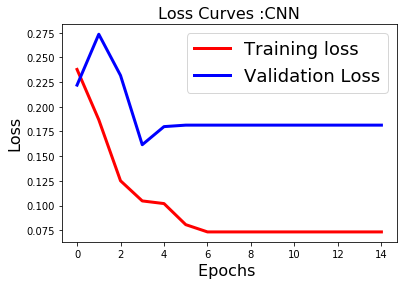

In [26]:
# Plot for Validation and Training Loss
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

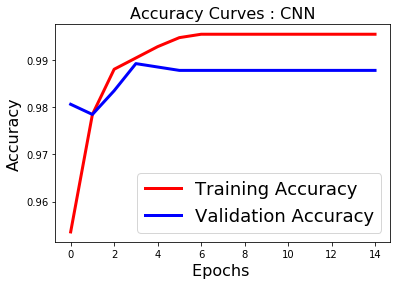

In [27]:
# Plot for Training and Validation Accuracy
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [28]:
model.save("model_CNN.h5")
print("Saved model to disk")

Saved model to disk


# 10. Training the RNN model

In [29]:
# Setting the embedding sequence
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

In [30]:
# Importing LSTM
from keras.layers import LSTM

In [31]:
l_lstm_1 = LSTM(256)(embedded_sequences) # Including embedding layer in LSTM
preds = Dense(2, activation='softmax')(l_lstm_1)

model2 = Model(sequence_input, preds)

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary()) # Output Layer

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         781700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 1,147,782
Trainable params: 1,147,782
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
# Checkpointer
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)   # Model Checkpointer callback

# 11. Fitting the RNN model

In [34]:
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=10, batch_size=256,callbacks=[cp])

Train on 4179 samples, validate on 1393 samples
Epoch 1/10
4179/4179 [==============================] - ETA: 8:16 - loss: 0.7751 - accuracy: 0.17 - ETA: 5:28 - loss: 0.5982 - accuracy: 0.51 - ETA: 4:06 - loss: 0.5125 - accuracy: 0.62 - ETA: 3:20 - loss: 0.4862 - accuracy: 0.66 - ETA: 2:49 - loss: 0.4405 - accuracy: 0.70 - ETA: 2:25 - loss: 0.4021 - accuracy: 0.73 - ETA: 2:05 - loss: 0.3680 - accuracy: 0.76 - ETA: 1:48 - loss: 0.3448 - accuracy: 0.78 - ETA: 1:32 - loss: 0.3232 - accuracy: 0.79 - ETA: 1:17 - loss: 0.3060 - accuracy: 0.81 - ETA: 1:04 - loss: 0.2925 - accuracy: 0.82 - ETA: 51s - loss: 0.2782 - accuracy: 0.8408 - ETA: 38s - loss: 0.2692 - accuracy: 0.848 - ETA: 26s - loss: 0.2559 - accuracy: 0.857 - ETA: 15s - loss: 0.2439 - accuracy: 0.865 - ETA: 3s - loss: 0.2341 - accuracy: 0.872 - 207s 49ms/step - loss: 0.2308 - accuracy: 0.8744 - val_loss: 0.0920 - val_accuracy: 0.9742


C:\Users\sudha\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
4179/4179 [==============================] - ETA: 2:40 - loss: 0.0704 - accuracy: 0.96 - ETA: 2:29 - loss: 0.0701 - accuracy: 0.96 - ETA: 2:13 - loss: 0.0697 - accuracy: 0.97 - ETA: 2:05 - loss: 0.0879 - accuracy: 0.97 - ETA: 1:55 - loss: 0.0800 - accuracy: 0.97 - ETA: 1:45 - loss: 0.0852 - accuracy: 0.97 - ETA: 1:35 - loss: 0.0872 - accuracy: 0.97 - ETA: 1:25 - loss: 0.0857 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0799 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0804 - accuracy: 0.97 - ETA: 55s - loss: 0.0835 - accuracy: 0.9737 - ETA: 44s - loss: 0.0811 - accuracy: 0.974 - ETA: 34s - loss: 0.0797 - accuracy: 0.974 - ETA: 24s - loss: 0.0771 - accuracy: 0.974 - ETA: 13s - loss: 0.0757 - accuracy: 0.974 - ETA: 3s - loss: 0.0728 - accuracy: 0.975 - 188s 45ms/step - loss: 0.0719 - accuracy: 0.9761 - val_loss: 0.0784 - val_accuracy: 0.9792
Epoch 3/10
4179/4179 [==============================] - ETA: 2:39 - loss: 0.0555 - accuracy: 0.98 - ETA: 2:29 - loss: 0.0442 - accuracy: 0.98 - ETA: 

# 12. Testing the RNN model

In [35]:
y_pred2 = model2.predict(x_val)
y_pred2 = np.argmax(y_pred2, axis=1)
y_pred2.shape

(1393,)

In [36]:
y_val2 = np.argmax(y_val, axis=1)
y_val2.shape

(1393,)

In [37]:
print(confusion_matrix(y_val2,y_pred2))

[[1196    6]
 [  13  178]]


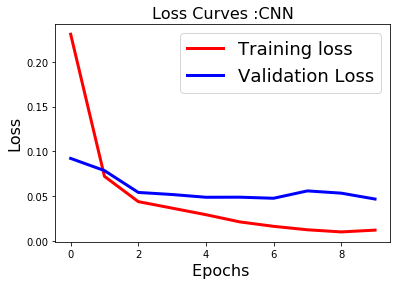

In [38]:
fig1 = plt.figure()
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

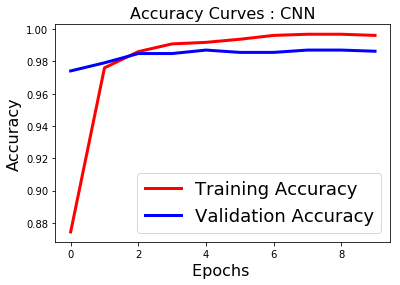

In [41]:
fig2=plt.figure()
plt.plot(history2.history['accuracy'],'r',linewidth=3.0)
plt.plot(history2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [42]:
model2.save("model_RNN.h5")
print("Saved model to disk")

Saved model to disk


# 13. Creating Spacy Text Categorizer

In [75]:
# Getting the train data
train_spam = spam.apply(lambda x: (x['Message'], x['Category']), axis=1)
train = train_spam.tolist()
train[:1]

[('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
  0)]

In [81]:
#functions from spacy documentation

# To create train and text df for training
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'SPAM': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

  
def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}
  
  
#("Number of texts to train from","t" , int)
n_texts=3000
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10


# 14. Fitting the Spacy Text Categorizer

In [82]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy

if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('SPAM')

# load the dataset
print("Loading email messages...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading email messages...
Using 3000 examples (2400 training, 600 evaluation)


# 15. Training the Spacy Text Categorizer

In [52]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
54.935	0.951	0.773	0.853
9.561	0.985	0.867	0.922
3.833	0.985	0.893	0.937
2.171	0.958	0.907	0.932
1.478	0.943	0.880	0.910
1.015	0.957	0.880	0.917
1.029	0.957	0.880	0.917
0.719	0.957	0.893	0.924
0.524	0.957	0.893	0.924
0.461	0.944	0.893	0.918


# 16. Testing the Spacy Text Categorizer

In [102]:
# Test the trained model

test_text= "Hello Andy,the meetings is at 5,dont forget"
doc = nlp(test_text)
test_text, doc.cats

('Hello Andy,the meetings is at 5,dont forget',
 {'SPAM': 0.0022743702866137028})

In [101]:
# Test the trained model

test_text= "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
doc = nlp(test_text)
test_text, doc.cats

("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 {'SPAM': 0.9946016073226929})